# <center>Group 5: Final Project</center>
- **Abdulraham Binobaid** aab8402
- **Alex Herron** ah5865
- **Beyza Kiper** bk2569
- **Brian Reilly** bjr224
- **Faleh Alshalwi** fa911  

<center>DS-GA 1007</center>
<center>Fall 2021</center>  
<center>5 December 2021</center>

# Contents
0. [The Yellow Taxi Dataset](#dataset_description)
1. [NYC OpenData via Socrata API](#API_soc)
    1. [Packages](#packages1)
    2. [Counts: 2009–2020](#API_counts)
    3. [MetaData: Cached Summary Statistics](#API_meta)
    4. [Features with Null Values](#API_null)
2. [Instances over Time](#API_inst)
    1. [Rides by Month, by Week, and by Day](#API_dwm)
    2. [Rides by Day of Week](#API_dow)
    3. [Rides by Hour of Day](#API_hod)
3. [2019 Yellow Taxi Dataset with datatable](#DT_describe)
    1. [Packages](#packages2)
    2. [Data Cleaning 1: From MetaData](#DT_clean1)
    3. [Stratum as Hour of Year](#DT_stratum)
    4. [Data Cleaning 2 : Pre-Sample](#DT_clean2)
4. [Stratified Sampling](#DT_sample)
5. [Sample Feature Description](#Sample_Analysis)
    1. [Travel Time in Minutes](#TT_min)
    2. [Average Speed (in mph)](#speed)
6. [Analyses](#Analyses)
7. [Visualizations](#Visualizations)

# <center>0. The *Yellow Taxi* Dataset<a name="dataset_description"></a></center>
The New York City Taxi and Limousine Commission (NYC TLC: https://www1.nyc.gov/site/tlc/about/about-tlc.page) provides trip data for Yellow Taxis, Green Taxis (since August 2013), For-Hire Vehicles (since 2015), and High Volume For-Hire Vehicles (since 2020). The data is provided under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP).
On the TLC website, the data is downloadable by month from 2009 to July 2021 (https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).  

The full data set by year is available through NYC OpenData (https://data.cityofnewyork.us/), where it can be downloaded as a CSV, queried via the Socrata Open Data API, or visualized online.

# <center>1. NYC OpenData via Socrata API<a name="API_soc"></a></center>
The Socrata Open Data API access to NYC OpenData via Socrata Query Language (SoQL) queries.  
*All queries have been commented out after being run to avoid taxing the API.*

## 1.A Packages<a name="packages1"></a>

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import calendar
import datetime
#from sodapy import Socrata # For SoQL queries of the API; commented out to void live querying
import pickle # to save objects from API to avoid data throttling, etc
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

## 1.B Counts: 2009–2020<a name="API_counts">

In [2]:
# NYC Open Data
data_url = 'data.cityofnewyork.us'
app_token = 'T6QyhTWaISD0SaHSdYtuMgdiw'   # Brian's NYC Data App Token for this project; can also use None
# client = Socrata(data_url,app_token)      # Create the client to point to the API endpoint  
# client.timeout = 120                      # Set the query timeout in seconds

Although we will be working with the 2019 data, it might be interesting to see how the data has changed over time. The NYC OpenData site only provides the datasets for five years (2009, 2017, 2018, 2019, 2020), with other years available only via API query. So in order to plot the change in, say, number of rides over time, only SoQL queries are possible.

We used the following SoQL query to get the number of rides with the following SoQL query:  
&emsp;`SELECT`  
&emsp;&emsp;	`COUNT(*)`

Each dataset is associated with cached metadata. We downloaded the metadata only for Yellow Taxi rides in 2019.

In [3]:
# Taxi Trip Data (NYC)
data_set_ids_dict = dict()
data_set_ids_dict['Yellow'] = {2009: 'f9tw-8p66',
                               #2010: None, # Not on OpenData
                               2011: 'uwyp-dntv',
                               2012: 'kerk-3eby',
                               2013: 't7ny-aygi',
                               2014: 'gkne-dk5s',
                               2015: '2yzn-sicd', # Says "January to June in 2015" but has last pick up as 31 Dec 2015 11:59pm
                               2016: 'uacg-pexx', # Also says only to June but is full year
                               2017: 'biws-g3hs',
                               2018: 't29m-gskq',
                               2019: '2upf-qytp',
                               2020: 'kxp8-n2sj'}
data_set_ids_dict['Green'] = {2013: 'ghpb-fpea',
                              2014: '2np7-5jsg',
                              2015: 'gi8d-wdg5',
                              2016: 'hvrh-b6nb',
                              2017: '5gj9-2kzx',
                              2018: 'w7fs-fd9i',
                              2019: 'q5mz-t52e',
                              2020: 'pkmi-4kfn'}
data_set_ids_dict['For_Hire'] = {#2015: 'None, # Not on OpenData
                              2016: 'yini-w76t',
                              2017: 'avz8-mqzz',
                              2018: 'am94-epxh',
                              2019: 'u6nh-b56h',
                              2020: 'm3yx-mvk4'}
data_set_ids_dict['High_Volume'] = {2019: '4p5c-cbgn',
                                   2020: 'yrt9-58g8'}
# MetaData for 2019 and Total Instances
# meta_data_dict = dict()
# rides_year_dict = dict()
# for key_type in data_set_ids_dict.keys():
#     rides_year_dict[key_type] = dict()
#     for key_year in data_set_ids_dict[key_type].keys():
#         rides_year_dict[key_type][key_year] = int(client.get(data_set_ids_dict[key_type][key_year], select="COUNT(*)")[0]['COUNT'])
#         if (key_type == 'Yellow') & (key_year == 2019):
#             meta_data_dict[key_year] = client.get_metadata(data_set_ids_dict[key_type][key_year])

# Pickle
## Save
# f = open('meta_data_dict.pkl', 'wb')
# pickle.dump(meta_data_dict, f, -1)
# f.close()
# f = open('rides_year_dict.pkl', 'wb')
# pickle.dump(rides_year_dict, f, -1)
# f.close()
## Open
f = open('meta_data_dict.pkl', 'rb')
meta_data_dict = pickle.load(f)     
f.close()
f = open('rides_year_dict.pkl', 'rb')
rides_year_dict = pickle.load(f)     
f.close()  

In [4]:
# Total Instances by Year and by Type
rides_year_df = pd.DataFrame(rides_year_dict)
rides_year_df['Total'] = rides_year_df.sum(axis = 1) # Total for all types
rides_year_df['Total_YG'] = rides_year_df[['Yellow', 'Green']].sum(axis = 1) # Total for Yellow and Green Taxis
rides_year_df

,Yellow,Green,For_Hire,High_Volume,Total,Total_YG
2009,170896055,NaN,NaN,NaN,170896055.0,170896055.0
2011,135335924,NaN,NaN,NaN,135335924.0,135335924.0
2012,167331308,NaN,NaN,NaN,167331308.0,167331308.0
2013,173179759,1210811.0,NaN,NaN,174390570.0,174390570.0
2014,165114361,15837001.0,NaN,NaN,180951362.0,180951362.0
2015,146087462,19233765.0,NaN,NaN,165321227.0,165321227.0
2016,131165043,16385532.0,132830651.0,NaN,280381226.0,147550575.0
2017,113496874,11740667.0,200283593.0,NaN,325521134.0,125237541.0
2018,112234626,8807303.0,260766056.0,NaN,381807985.0,121041929.0
2019,84399019,6044050.0,42084899.0,234629119.0,367157087.0,90443069.0


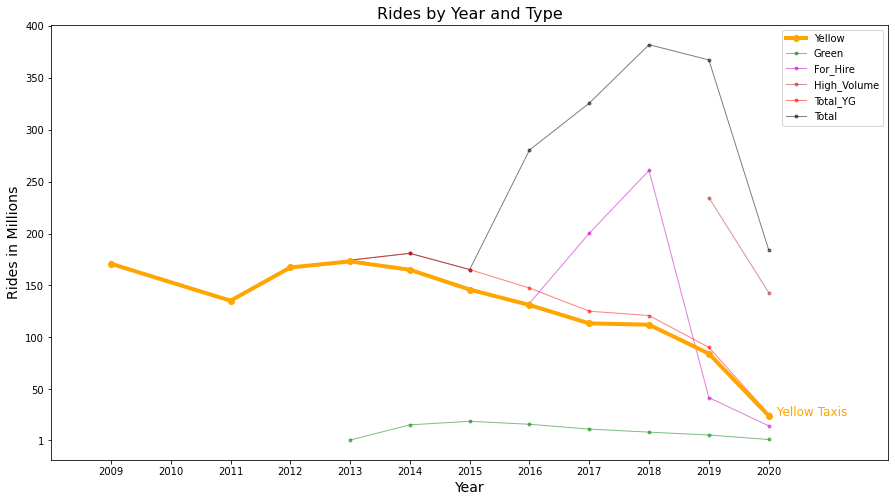

In [5]:
# Rides Over the Last Decade By Type
fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(111)
color_dict = {'Yellow': 'orange', 'Green': 'green', 'For_Hire': 'm', 'High_Volume': 'brown', 'Total_YG': 'red', 'Total': 'black'}

# Plot Rides by Type and Year
for column in rides_year_df:
    if column == 'Yellow':
        next
    else:
        ax.plot(rides_year_df[column], marker='.', color=color_dict[column], linewidth=1, alpha=0.5, label = column)

# Thicker Line for Yellow Taxi Data
ax.plot(rides_year_df['Yellow'], marker='o', color=color_dict['Yellow'], linewidth=4, alpha=1, label = 'Yellow')
# Annotation
ax.text(2020, rides_year_df.Yellow.tail(1), '  Yellow Taxis', horizontalalignment='left', size='large', color='orange')
 
# Legend
handles, labels = ax.get_legend_handles_labels()
order = [5,0,1,2,4,3]
ax.legend([handles[i] for i in order],[labels[i] for i in order])

# Titles, and ticks
plt.title("Rides by Year and Type", loc='center', fontsize=16, fontweight=0, color='black')
plt.xlim(2008, 2022)
plt.xticks(np.arange(2009, 2021, step = 1), np.arange(2009, 2021, step = 1))
rides_min = (int("{:e}".format(rides_year_df.min().min())[0])) * (10**int("{:e}".format(rides_year_df.min().min())[-1]))
rides_max = (int("{:e}".format(rides_year_df.Total.max())[0]) + 1) * (10**int("{:e}".format(rides_year_df.Total.max())[-1]))
y_labels = np.concatenate((np.array(rides_min/1000000), np.arange(rides_min/1000000 + 49, (rides_max/1000000) + 50, step = 50)), axis=None).astype('int')
y_ticks = np.concatenate((np.array(rides_min), np.arange(rides_min + 49_000_000, rides_max + 50_000_000, step = 50_000_000)), axis=None).astype('int')
plt.yticks(y_ticks, y_labels)
plt.xlabel("Year", fontsize = 14)
plt.ylabel("Rides in Millions", fontsize = 14)
plt.show()

**It is possible that 2020 is not the full year, given typos noted below. But also, COVID.**

## 1.C MetaData: Cached Summary Statistics<a name="API_meta">
    The datasets on NYC OpenData come with metadata, which includes cached summary statistics for its features.

### Features

In [6]:
# List of Features
features_l = []
for i in range(len(meta_data_dict[2019]['columns'])):
        feature = meta_data_dict[2019]['columns'][i]['name']
        features_l.append(feature)
features_l

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge']

### Cached Summary Statistics
For each feature, the metadata has cached:
- `largest` (i.e., maximum value)
- `non_null` (count)
- `null` (count)
- `top` (by count)
- `smallest` (i.e., minimum value)
- `cardinality` (i.e., number of unique values).  

In [7]:
# Cached Contents for Features
cachedContents_l = list(meta_data_dict[2019]['columns'][0]['cachedContents'].keys())
cachedContents_l

['largest', 'non_null', 'null', 'top', 'smallest', 'cardinality']

In [8]:
# Cached Statistics
features_dict = dict()
feature_dict = {'type': None, 'non_null': None, 'null': None, 'smallest': None, 'largest': None, 'cardinality': None, 'top_item': None, 'top_item_ct': None}

for i in range(len(meta_data_dict[2019]['columns'])):
    temp_dict = feature_dict.copy()
    temp_dict['type'] = meta_data_dict[2019]['columns'][i]['dataTypeName']
    temp_dict['non_null'] = int(meta_data_dict[2019]['columns'][i]['cachedContents']['non_null'])
    temp_dict['null'] = int(meta_data_dict[2019]['columns'][i]['cachedContents']['null'])
    temp_dict['smallest'] = meta_data_dict[2019]['columns'][i]['cachedContents']['smallest']
    temp_dict['largest'] = meta_data_dict[2019]['columns'][i]['cachedContents']['largest']
    temp_dict['cardinality'] = int(meta_data_dict[2019]['columns'][i]['cachedContents']['cardinality'])
    temp_dict['top_item'] = meta_data_dict[2019]['columns'][i]['cachedContents']['top'][0]['item']
    temp_dict['top_item_ct'] = int(meta_data_dict[2019]['columns'][i]['cachedContents']['top'][0]['count'])
    features_dict[meta_data_dict[2019]['columns'][i]['name']] = temp_dict
features_df = pd.DataFrame.from_dict(features_dict, orient='index')
#features_df.to_csv('features_df.csv')
#pd.set_option('display.max_rows', feature_df.shape[0])
features_df

,type,non_null,null,smallest,largest,cardinality,top_item,top_item_ct
VendorID,number,84152418,246601,1,4,3,2,53517181
tpep_pickup_datetime,calendar_date,84399019,0,2001-01-01T00:02:08.000,2090-12-31T06:41:26.000,26154014,2019-02-02T12:19:58.000,49
tpep_dropoff_datetime,calendar_date,84399019,0,2001-01-01T01:00:02.000,2090-12-31T07:18:49.000,26176226,2019-10-27T00:00:00.000,93
passenger_count,number,84152418,246601,0,9,10,1,59108834
trip_distance,number,84399019,0,-37264.53,45977.22,9519,0.90,1633310
RatecodeID,number,84152418,246601,1,99,7,1,81165672
store_and_fwd_flag,text,84152418,246601,N,Y,2,N,83461219
PULocationID,number,84399019,0,1,265,263,237,3641682
DOLocationID,number,84399019,0,1,265,263,236,3429838
payment_type,number,84152418,246601,1,5,5,1,60622269


NB:
- We notice that for 5 of the 6 features with null values, they have the same number of nulls (246601).
- The earliest (`smallest`) pickup/dropoff date is from 2001.
- The latest (`largest`) pickup/dropoff date is from 2090.
- There are negative dollar amounts in almost all monetary features:
    - `fare_amount`; `extra`; `mta_tax`; `tip_amount`; `tolls_amount`; `improvement_surcharge`; `total_amount`.
- There is a negative distance in `trip_distance`.  

The `top` feature, which is the most frequent value, is not particularly useful for pickup/dropoff date, since that value is precise to the second (nanoseconds are indicated).

## 1.D Features with Null Values<a name="API_null"></a></center>

In [9]:
# Which Features Have NULLs
features_df[features_df.null >0].index

Index(['VendorID', 'passenger_count', 'RatecodeID', 'store_and_fwd_flag',
       'payment_type', 'congestion_surcharge'],
      dtype='object')

Most of these are uninformative to our questions.

Passenger count might be interesting.

Congestion surcharge as a null might be interpretable as 0?

In [10]:
# Each Individual Feature with Nulls: Null by Month
nulls_features_dict = {}
print('SoQL Queries:\n')
for feature in features_df[features_df.null >0].index:
    query_null_feature = 'SELECT\n\tdate_extract_m(tpep_pickup_datetime), COUNT(*)\nWHERE\n' + '\t' + feature + ' IS NULL\n' + 'GROUP BY\n\tdate_extract_m(tpep_pickup_datetime)'
    print(query_null_feature)
    print('- ' * 20)
    # Run or Open Pickle
#     nulls_features_dict[feature] = client.get(data_set_ids_dict['Yellow'][2019], query = query_null_feature)
# Pickle
## Save
# f = open('nulls_features_dict.pkl', 'wb')
# pickle.dump(nulls_features_dict, f, -1)
# f.close()
## Open
f = open('nulls_features_dict.pkl', 'rb')
nulls_features_dict = pickle.load(f)     
f.close()

SoQL Queries:

SELECT
	date_extract_m(tpep_pickup_datetime), COUNT(*)
WHERE
	VendorID IS NULL
GROUP BY
	date_extract_m(tpep_pickup_datetime)
- - - - - - - - - - - - - - - - - - - - 
SELECT
	date_extract_m(tpep_pickup_datetime), COUNT(*)
WHERE
	passenger_count IS NULL
GROUP BY
	date_extract_m(tpep_pickup_datetime)
- - - - - - - - - - - - - - - - - - - - 
SELECT
	date_extract_m(tpep_pickup_datetime), COUNT(*)
WHERE
	RatecodeID IS NULL
GROUP BY
	date_extract_m(tpep_pickup_datetime)
- - - - - - - - - - - - - - - - - - - - 
SELECT
	date_extract_m(tpep_pickup_datetime), COUNT(*)
WHERE
	store_and_fwd_flag IS NULL
GROUP BY
	date_extract_m(tpep_pickup_datetime)
- - - - - - - - - - - - - - - - - - - - 
SELECT
	date_extract_m(tpep_pickup_datetime), COUNT(*)
WHERE
	payment_type IS NULL
GROUP BY
	date_extract_m(tpep_pickup_datetime)
- - - - - - - - - - - - - - - - - - - - 
SELECT
	date_extract_m(tpep_pickup_datetime), COUNT(*)
WHERE
	congestion_surcharge IS NULL
GROUP BY
	date_extract_m(tpep_pickup

In [11]:
null_features_l = []
for feature in nulls_features_dict:
    temp_df = pd.DataFrame(nulls_features_dict[feature], index = [int(x['date_extract_m_tpep_pickup_datetime']) for x in nulls_features_dict[feature]]).rename(columns={"COUNT": feature + "_Count", "date_extract_m_tpep_pickup_datetime": 'Month'})
    null_features_l.append(temp_df.drop(columns = 'Month'))
null_features_df = pd.concat(null_features_l, axis = 1)

In [12]:
null_features_df = null_features_df.astype('float')
null_features_df = null_features_df.fillna(0)

In [13]:
null_features_df

,VendorID_Count,passenger_count_Count,RatecodeID_Count,store_and_fwd_flag_Count,payment_type_Count,congestion_surcharge_Count
1,0.0,0.0,0.0,0.0,0.0,4855563.0
2,0.0,0.0,0.0,0.0,0.0,10.0
3,0.0,0.0,0.0,0.0,0.0,5.0
4,0.0,0.0,0.0,0.0,0.0,6.0
5,0.0,0.0,0.0,0.0,0.0,1.0
6,0.0,0.0,0.0,0.0,0.0,2.0
7,33959.0,33959.0,33959.0,33959.0,33959.0,6.0
8,33321.0,33321.0,33321.0,33321.0,33321.0,1.0
9,34089.0,34089.0,34089.0,34089.0,34089.0,2.0
10,46723.0,46723.0,46723.0,46723.0,46723.0,0.0


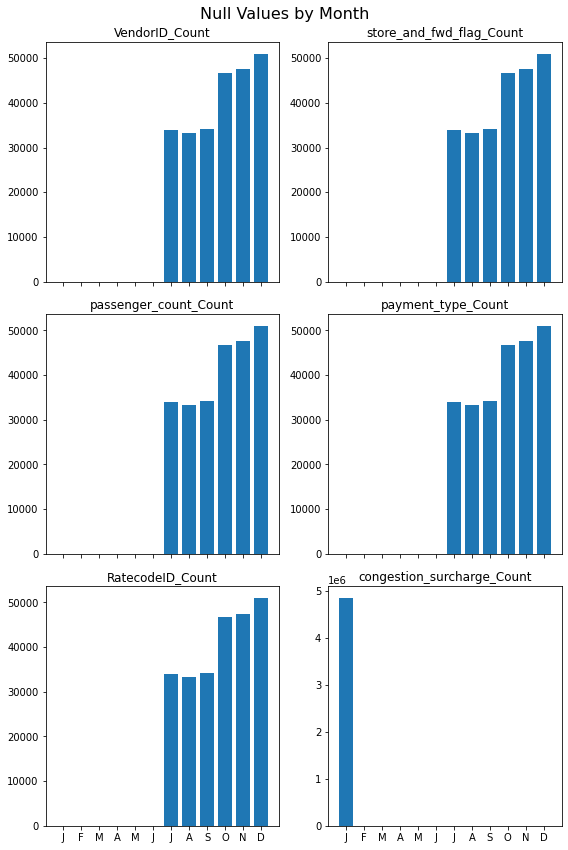

In [14]:
fig, ax = plt.subplots(nrows = int(null_features_df.shape[1]/2), ncols = 2, sharex = True, figsize=(8, 12), tight_layout=True)
for i, feature in enumerate(null_features_df.columns):
    if i < int(null_features_df.shape[1]/2):
        j = i
    else:
        j = i - int(null_features_df.shape[1]/2)
    ax[j, int(i>2)].set(title = feature)
    ax[j, int(i>2)].bar(np.arange(1,13), height = null_features_df.loc[:,feature], tick_label = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
fig.suptitle('Null Values by Month', fontsize = 16)
plt.show()

We see that there are two types of null features: five have a similar distribution; one is unique. We take each group in turn.

### Features: `VendorID`, `passenger_count`, `RatecodeID`, `store_and_fwd_flag`, `payment_type`
Five of the six features seem to have nulls at the same time; to check, we see where the entries that have all the nulls at the same time.

In [15]:
# Query
query_nulls2 = 'SELECT\n\tdate_extract_m(tpep_pickup_datetime), COUNT(*)\nWHERE\n'
for i, feature in enumerate(null_features_df.iloc[:,0:-1].columns):
    if i == 0:
        query_nulls2 = query_nulls2 + '\t' + feature[0:-6] + ' IS NULL\n'
    else:
        query_nulls2 = query_nulls2 + '\tAND ' + feature[0:-6] + ' IS NULL\n'
query_nulls2 = query_nulls2 + 'GROUP BY\n\tdate_extract_m(tpep_pickup_datetime)'
print(f'SoQL Query:\n{query_nulls2}')
# Send query
# query_nulls2_results = client.get(data_set_ids_dict['Yellow'][2019], query = query_nulls2)
# Pickle
## Save
# f = open('query_nulls2_results.pkl', 'wb')
# pickle.dump(query_nulls2_results, f, -1)
# f.close()
## Open
f = open('query_nulls2_results.pkl', 'rb')
query_nulls2_results = pickle.load(f)     
f.close()

SoQL Query:
SELECT
	date_extract_m(tpep_pickup_datetime), COUNT(*)
WHERE
	VendorID IS NULL
	AND passenger_count IS NULL
	AND RatecodeID IS NULL
	AND store_and_fwd_flag IS NULL
	AND payment_type IS NULL
GROUP BY
	date_extract_m(tpep_pickup_datetime)


In [16]:
nulls2_df = pd.DataFrame(query_nulls2_results, index = range(7,13))
pd.concat([nulls2_df,null_features_df.iloc[6:12,0:-1]], axis = 1).iloc[:,1:]

,COUNT,VendorID_Count,passenger_count_Count,RatecodeID_Count,store_and_fwd_flag_Count,payment_type_Count
7,33959,33959.0,33959.0,33959.0,33959.0,33959.0
8,33321,33321.0,33321.0,33321.0,33321.0,33321.0
9,34089,34089.0,34089.0,34089.0,34089.0,34089.0
10,46723,46723.0,46723.0,46723.0,46723.0,46723.0
11,47491,47491.0,47491.0,47491.0,47491.0,47491.0
12,51018,51018.0,51018.0,51018.0,51018.0,51018.0


We see that everywhere *any* of these features is null, all of them are. For whatever reason, from July 2019 through December 2019, a certain percentage of rides (see below) did not report these features. We consider whether to drop these nulls below based on how prevalent they are by percentage of counts for each month.

### Feature: `congestion_surcharge`

According to the NYC TLC, the "congestion surcharge" took effect on 1 January 2019. Our data indicates that it took a month for the taxis to report this charge, as the nulls are almost entirely in January. We take a deeper look at the January data by day for the surcharge.

In [17]:
print('SoQL Query:\n')
query_null_congestion = 'SELECT\n\tdate_extract_d(tpep_pickup_datetime), COUNT(*)\nWHERE\n' + '\tcongestion_surcharge IS NULL\n' + '\tAND date_extract_m(tpep_pickup_datetime) = 1\n' + 'GROUP BY\n\tdate_extract_d(tpep_pickup_datetime)'
print(query_null_congestion)
# query_null_congestion_results = client.get(data_set_ids_dict['Yellow'][2019], query=query_null_congestion)
# Pickle
## Save
# f = open('query_null_congestion_results.pkl', 'wb')
# pickle.dump(query_null_congestion_results, f, -1)
# f.close()
## Open
f = open('query_null_congestion_results.pkl', 'rb')
query_null_congestion_results = pickle.load(f)     
f.close()

SoQL Query:

SELECT
	date_extract_d(tpep_pickup_datetime), COUNT(*)
WHERE
	congestion_surcharge IS NULL
	AND date_extract_m(tpep_pickup_datetime) = 1
GROUP BY
	date_extract_d(tpep_pickup_datetime)


    Day in January  Number of Nulls
0                1           189080
1                2           197852
2                3           222875
3                4           235053
4                5           236037
5                6           208194
6                7           227762
7                8           236155
8                9           254671
9               10           280648
10              11           290607
11              12           264567
12              13           226924
13              14           244102
14              15           266134
15              16           271419
16              17           283409
17              18           265730
18              19           235786
19              20           202374
20              21             1660
21              22             2344
22              23             2493
23              24             2485
24              25             2590
25              26             2594
26              27          

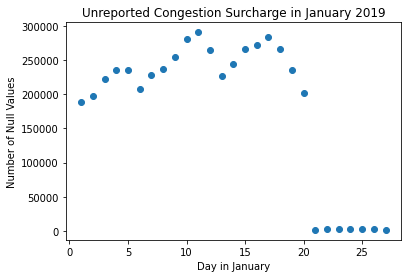

In [18]:
null_congestion_df = pd.DataFrame(query_null_congestion_results).rename(columns = {'date_extract_d_tpep_pickup_datetime': 'Day in January', 'COUNT': 'Number of Nulls'})
null_congestion_df = null_congestion_df.astype('int')
print(null_congestion_df)
plt.scatter(null_congestion_df['Day in January'], null_congestion_df['Number of Nulls'])
plt.ylabel('Number of Null Values')
plt.xlabel('Day in January')
plt.title('Unreported Congestion Surcharge in January 2019')
plt.show()

The New York State Congestion Surcharge of USD2.50 (Yellow Taxi) USD0.75 (any shared ride) for all trips that begin, end or pass through Manhattan south of 96th Street can double the base fare of a taxi trip. Still, we will not throw out these null values since the trips prior to c. 20 January 2019 would not be usable.

### Feature: `passenger_count`
NYC taxis limit the number of passengers. Any trip with 0 passangers obviously has some issue. But a Yellow Taxi can carry at most 4 or 5 adults depending on whether it is a 4- or 5-passenger taxi. One additional child below the age of seven is also allowed above this limit.  
The cached summary statistics above indicate that some rides have 0, 8, or 9.

In [19]:
print('SoQL Query:\n')
query_passenger_ct_q = 'SELECT\n\tpassenger_count, COUNT(*)\nGROUP BY\n\tpassenger_count'
print(query_passenger_ct_q)
# query_passenger_ct_results = client.get(data_set_ids_dict['Yellow'][2019], query=query_passenger_ct_q)
# Pickle
## Save
# f = open('query_passenger_ct_results.pkl', 'wb')
# pickle.dump(query_passenger_ct_results, f, -1)
# f.close()
## Open
f = open('query_passenger_ct_results.pkl', 'rb')
query_passenger_ct_results = pickle.load(f)     
f.close()

SoQL Query:

SELECT
	passenger_count, COUNT(*)
GROUP BY
	passenger_count


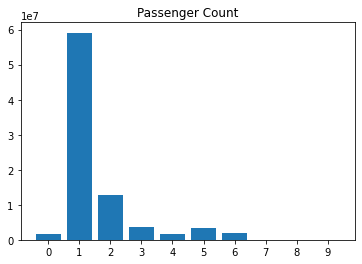

In [20]:
passenger_count_df = pd.DataFrame(query_passenger_ct_results)
passenger_count_df.dropna(inplace = True)
passenger_count_df = passenger_count_df.astype('int')
plt.bar(x = passenger_count_df.passenger_count, height = passenger_count_df.COUNT)
plt.xticks(passenger_count_df.passenger_count)
plt.title('Passenger Count')
plt.show()

We see that the vast majority of rides are one-passenger rides. Other than rides with 0 passengers, it does not seem like any other errors will pose problems, since eliminating rides with 7, 8, or 9 passengers will have little effect.

### Feature: `RatecodeID`
There should be 6 possible rate codes:
- 1= Standard rate;
- 2=JFK;
- 3=Newark;
- 4=Nassau or Westchester;
- 5=Negotiated fare;
- 6=Group ride.

Rate code 5 can indicate that there was a mistake in `payment_type`. We note that the cardinality for this feature is 7 and largest is 99. That rate code must be an error and we will eliminate `RatecodeID` = 7 in cleaning the data.

In [21]:
print('SoQL Query:\n')
query_RatecodeID_q = 'SELECT\n\tRatecodeID, COUNT(*)\nGROUP BY\n\tRatecodeID'
print(query_RatecodeID_q)
# query_RatecodeID_results = client.get(data_set_ids_dict['Yellow'][2019], query=query_RatecodeID_q)
# Pickle
## Save
# f = open('query_RatecodeID_results.pkl', 'wb')
# pickle.dump(query_RatecodeID_results, f, -1)
# f.close()
## Open
f = open('query_RatecodeID_results.pkl', 'rb')
query_RatecodeID_results = pickle.load(f)     
f.close()

SoQL Query:

SELECT
	RatecodeID, COUNT(*)
GROUP BY
	RatecodeID


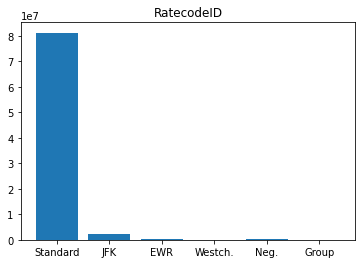

In [22]:
ratecodes_l = ['Standard', 'JFK', 'EWR', 'Westch.', 'Neg.', 'Group']
passenger_RatecodeID_df = pd.DataFrame(query_RatecodeID_results)
passenger_RatecodeID_df.dropna(inplace = True)
passenger_RatecodeID_df = passenger_RatecodeID_df.astype('int')
plt.bar(x = passenger_RatecodeID_df.RatecodeID[:6], height = passenger_RatecodeID_df.COUNT[:6])
plt.xticks(passenger_RatecodeID_df.RatecodeID[:6], labels = ratecodes_l[:6])
plt.title('RatecodeID')
plt.show()

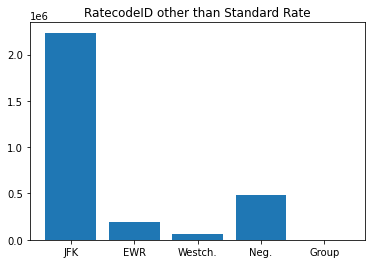

In [23]:
passenger_RatecodeID_df = pd.DataFrame(query_RatecodeID_results)
passenger_RatecodeID_df.dropna(inplace = True)
passenger_RatecodeID_df = passenger_RatecodeID_df.astype('int')
plt.bar(x = passenger_RatecodeID_df.RatecodeID[1:6], height = passenger_RatecodeID_df.COUNT[1:6])
plt.xticks(passenger_RatecodeID_df.RatecodeID[1:6], labels = ratecodes_l[1:6])
plt.title('RatecodeID other than Standard Rate')
plt.show()

While the vast majority of rides are standard fare, we note that JFK is more frequented by taxis than EWR.

### Feature: `Payment_type`
There should be 6 possible payment types:
- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute
- 5= Unknown
- 6= Voided trip

Payment types 3, 4, 5, and 6 should be eliminated during cleaning. According to the TLC, payment type 2 ('cash') does not necessarily provide information about tip amount.  

We noted that the cached statistics tell us that this feature has a cardinality of 5, so one payment type is missing. Either the documentation provided on NYC OpenData is incorrect (it dates to 2018 even though it is for 2019) or there were no voided trips.

In [24]:
print('SoQL Query:\n')
query_Payment_type_q = 'SELECT\n\tPayment_type, COUNT(*)\nGROUP BY\n\tPayment_type'
print(query_Payment_type_q)
# query_Payment_type_results = client.get(data_set_ids_dict['Yellow'][2019], query=query_Payment_type_q)
# Pickle
## Save
# f = open('query_Payment_type_results.pkl', 'wb')
# pickle.dump(query_Payment_type_results, f, -1)
# f.close()
## Open
f = open('query_Payment_type_results.pkl', 'rb')
query_Payment_type_results = pickle.load(f)     
f.close()

SoQL Query:

SELECT
	Payment_type, COUNT(*)
GROUP BY
	Payment_type


In [25]:
passenger_Payment_type_df = pd.DataFrame(query_Payment_type_results)
passenger_Payment_type_df.dropna(inplace = True)
passenger_Payment_type_df = passenger_Payment_type_df.astype('int')
passenger_Payment_type_df

,Payment_type,COUNT
0,1,60622269
1,2,22896312
2,3,447241
3,4,186563
4,5,33


Again the vast majority of rides were paid by credit card or cash. The number of cash rides poses a problem since they do not necessarily report tip amount. In cleaning we will eliminate the rides with no charge or disputed or voided charges.

# <center>2. Instances over Time<a name="API_inst"></a></center>

## 2.A Rides by Month, by Week, and by Day<a name="API_dwm">

### Rides by Month

In [26]:
# Instance by Month
# 1–12

# SoQL Query
instances_month_q = '''
SELECT
    COUNT(*)
GROUP BY
    date_extract_m(tpep_pickup_datetime)
'''
print(f'SoQL Query:\n{instances_month_q}')
# instances_month_r = client.get(data_set_ids_dict['Yellow'][2019], query = instances_month_q)
# ## Add Counts from DB to DataFrame
# months_2019_df = pd.DataFrame.from_dict(instances_month_r).rename(columns={"COUNT": "Count"})
# ## Add Hours
# months_2019_df['Month'] = calendar.month_abbr[1:13]
# ## Make Sure dtypes are int
# months_2019_df['Count'] = months_2019_df['Count'].astype(int)
# ## Save to CSV
# months_2019_df.to_csv('2019_Rides_Month.csv')
## Read CSV
months_2019_df = pd.read_csv('2019_Rides_Month.csv')

SoQL Query:

SELECT
    COUNT(*)
GROUP BY
    date_extract_m(tpep_pickup_datetime)



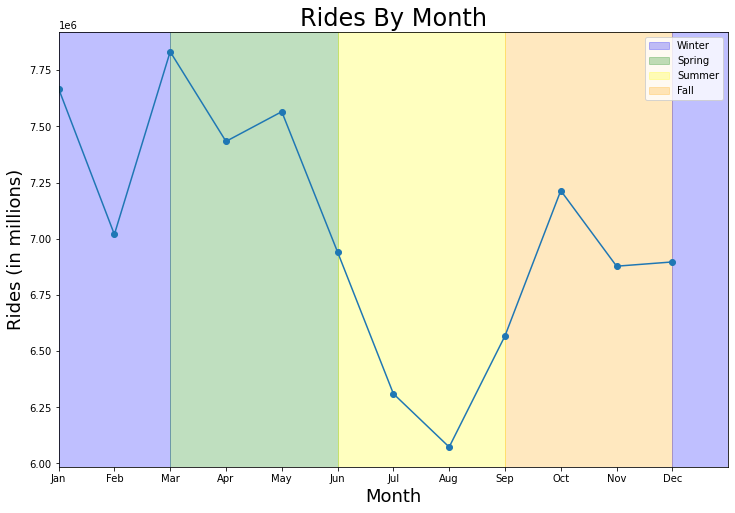

In [27]:
# Instance by Month
## Visualizations
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
ax.plot(months_2019_df['Month'], months_2019_df['Count'], marker = 'o')
ax.axvspan(0, 2, alpha=0.25, color='blue', label = 'Winter')
ax.axvspan(2, 5, alpha=0.25, color='green', label = 'Spring')
ax.axvspan(5, 8, alpha=0.25, color='yellow', label = 'Summer')
ax.axvspan(8, 11, alpha=0.25, color='orange', label = 'Fall')
ax.axvspan(11, 12, alpha=0.25, color='blue', label = '_Winter')
plt.xlim((0,12))
plt.title('Rides By Month', fontsize=24)
plt.xlabel('Month', fontsize=18)
plt.ylabel('Rides (in millions)', fontsize=18)
plt.legend(loc = 1)
plt.show()

Now that we know how many rides there are by month, we can see what percentage of rides have null values for the group of features that share nulls: `VendorID_Count`, `passenger_count_Count`, `RatecodeID_Count`, `store_and_fwd_flag_Count`, and `payment_type_Count`.

In [28]:
months_2019_df['Month_no'] = list(range(1,13))
months_2019_df = months_2019_df.set_index(months_2019_df['Month_no'])
nulls_by_month_df = pd.concat([months_2019_df, nulls2_df], axis = 1)
nulls_by_month_df.COUNT = pd.to_numeric(nulls_by_month_df.COUNT)
nulls_by_month_df = nulls_by_month_df.fillna(0)
nulls_by_month_df['Percent_Null'] = nulls_by_month_df['COUNT'] / nulls_by_month_df['Count']
nulls_by_month_df

,Unnamed: 0,Count,Month,Month_no,date_extract_m_tpep_pickup_datetime,COUNT,Percent_Null
1,0,7668167,Jan,1,0,0.0,0.000000
2,1,7019294,Feb,2,0,0.0,0.000000
3,2,7832372,Mar,3,0,0.0,0.000000
4,3,7433191,Apr,4,0,0.0,0.000000
5,4,7565395,May,5,0,0.0,0.000000
6,5,6940814,Jun,6,0,0.0,0.000000
7,6,6310383,Jul,7,7,33959.0,0.005381
8,7,6073093,Aug,8,8,33321.0,0.005487
9,8,6567628,Sep,9,9,34089.0,0.005190
10,9,7214110,Oct,10,10,46723.0,0.006477


Despite the number of instances with null values for five features being between 30k and 50k, the percentage of rides for which there is no such data is for every month less than 1%. In our sample, we will ignore these instances.

### Rides by Week of Year (1–52)

In [29]:
# Instance by WEEKofYEAR
## SoQL Query
instances_woy_q = '''
SELECT
    COUNT(*)
GROUP BY
    date_extract_woy(tpep_pickup_datetime)
'''
print(f'SoQL Query:\n{instances_woy_q}')
# instances_woy_r = client.get(data_set_ids_dict['Yellow'][2019], query = instances_woy_q)
# ## Add Counts from DB to DataFrame
# weeks_2019_df = pd.DataFrame.from_dict(instances_woy_r).rename(columns={"COUNT": "Count"})
# ## Make Sure dtypes are int
# weeks_2019_df['Count'] = weeks_2019_df['Count'].astype(int)
# ## Save to CSV
# weeks_2019_df.to_csv('2019_Rides_WoY.csv')
## Read CSV
weeks_2019_df = pd.read_csv('2019_Rides_WoY.csv')

SoQL Query:

SELECT
    COUNT(*)
GROUP BY
    date_extract_woy(tpep_pickup_datetime)



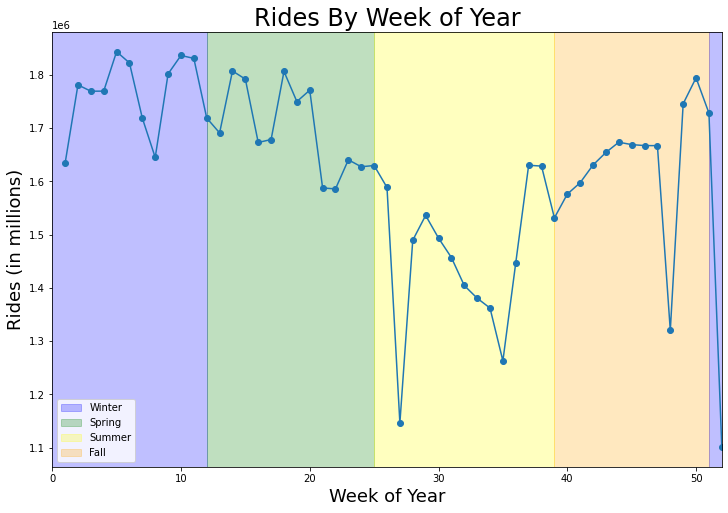

In [30]:
# Instance by Week
## Visualizations
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
ax.plot(range(1,53), weeks_2019_df['Count'], marker = 'o')
plt.title('Rides By Week of Year', fontsize=24)
plt.xlabel('Week of Year', fontsize=18)
plt.ylabel('Rides (in millions)', fontsize=18)
## Seasons
spring_week = pd.Timestamp(2019, 3, 20).isocalendar()[1]
summer_week = pd.Timestamp(2019, 6, 21).isocalendar()[1]
fall_week = pd.Timestamp(2019, 9, 23).isocalendar()[1]
winter_week = pd.Timestamp(2019, 12, 21).isocalendar()[1]
ax.axvspan(0, spring_week, alpha=0.25, color='blue', label = 'Winter')
ax.axvspan(spring_week, summer_week, alpha=0.25, color='green', label = 'Spring')
ax.axvspan(summer_week, fall_week, alpha=0.25, color='yellow', label = 'Summer')
ax.axvspan(fall_week, winter_week, alpha=0.25, color='orange', label = 'Fall')
ax.axvspan(winter_week, 52, alpha=0.25, color='blue', label = '_Winter')
plt.xlim(0,52)
plt.legend()
plt.show()

To identify the range of the weeks of the year starting with the first week we cannot use the `smallest` value in the cached contents of the metadata because it is an error, indicating the pickup date as 1 January 2001.

In [31]:
features_df.loc['tpep_pickup_datetime', 'smallest']

'2001-01-01T00:02:08.000'

We see that 1 January 2019 is the second day of the first week of the year, meaning 31 December 2018 is the start of the first week of 2019.

In [32]:
pd.Timestamp(2019, 1, 1).isocalendar() # 1 January 2019 is the second day of the first week of the year

(2019, 1, 2)

In [33]:
pd.Timestamp(2018, 12, 31).isocalendar() # 31 December 2018 is the start of the first week of 2019

(2019, 1, 1)

### Rides by Day of Year

In [34]:
# Instance by Day of Year
# Days of 2019
# SoQL Query
instances_day_q = '''
SELECT
    COUNT(*)
GROUP BY
    date_trunc_ymd(tpep_pickup_datetime)
'''
print(f'SoQL Query:\n{instances_day_q}')
# instances_day_r = client.get(data_set_ids_dict['Yellow'][2019], query = instances_day_q)

## Add Counts from DB to DataFrame
# days_2019_df = pd.DataFrame.from_dict(instances_day_r).rename(columns={"COUNT": "Count"})
# ## Remove Dates from Typos
# days_2019_df = days_2019_df.iloc[16:(16+365),:]
# ## Add Days
# days_2019_df['Day'] = np.arange(365)
# ## Make Sure dtypes are int
# days_2019_df['Count'] = days_2019_df['Count'].astype(int)
# ## Save to CSV
# days_2019_df.to_csv('2019_Rides_Day.csv')
## Read CSV
days_2019_df = pd.read_csv('2019_Rides_Day.csv')

SoQL Query:

SELECT
    COUNT(*)
GROUP BY
    date_trunc_ymd(tpep_pickup_datetime)



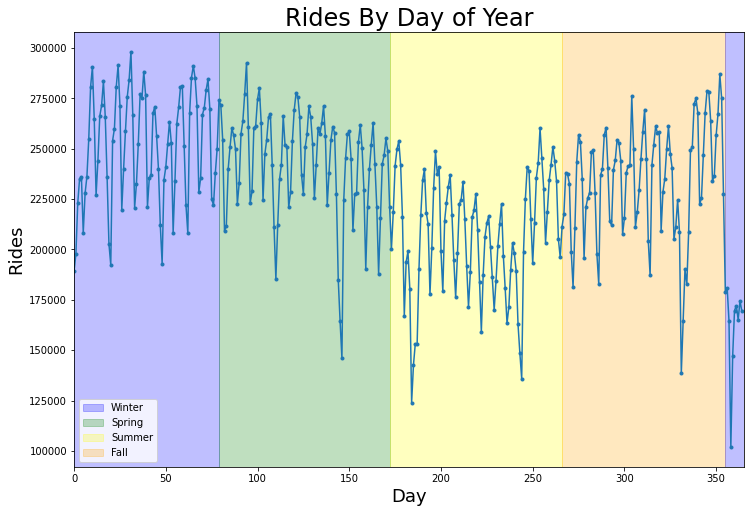

In [35]:
# Instance by Day
## Visualizations
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
ax.plot(days_2019_df['Day'], days_2019_df['Count'], marker = '.')
plt.title('Rides By Day of Year', fontsize=24)
plt.xlabel('Day', fontsize=18)
plt.ylabel('Rides', fontsize=18)
#ax.legend(bbox_to_anchor=(0, .7), title = 'f', ncol = 3, loc = 'center left', fontsize = 16)
## Seasons
spring_day = pd.Timestamp(2019, 3, 20).dayofyear
summer_day = pd.Timestamp(2019, 6, 21).dayofyear
fall_day = pd.Timestamp(2019, 9, 23).dayofyear
winter_day = pd.Timestamp(2019, 12, 21).dayofyear
ax.axvspan(0, spring_day, alpha=0.25, color='blue', label = 'Winter')
ax.axvspan(spring_day, summer_day, alpha=0.25, color='green', label = 'Spring')
ax.axvspan(summer_day, fall_day, alpha=0.25, color='yellow', label = 'Summer')
ax.axvspan(fall_day, winter_day, alpha=0.25, color='orange', label = 'Fall')
ax.axvspan(winter_day, 365, alpha=0.25, color='blue', label = '_Winter')
plt.legend()
plt.xlim(0,365)
plt.show()

## 2.B Rides by Day of Week<a name="API_dow">

In [36]:
# # What day of the week is 0 in DB?
# # Instance by DAYofWEEK
# DOW_q = '''
# SELECT
#     tpep_pickup_datetime
# WHERE
#     date_extract_dow(tpep_pickup_datetime) = 0
#     AND date_extract_y(tpep_pickup_datetime) = 2019
# LIMIT
#     1
# '''
# DOW_ex = client.get(data_set_ids_dict['Yellow'][2019], query = DOW_q)
# print(f'SoQL Query:\n{DOW_q}')
# print(f"The queried date returend is {DOW_ex[0]['tpep_pickup_datetime']}, which has a day-of-week in the database as 0.\n{pd.to_datetime(DOW_ex[0]['tpep_pickup_datetime']).day} {pd.to_datetime(DOW_ex[0]['tpep_pickup_datetime']).month_name()} 2019 is day number {pd.to_datetime(DOW_ex[0]['tpep_pickup_datetime']).weekday()} in pandas datetime, which is a {pd.to_datetime(DOW_ex[0]['tpep_pickup_datetime']).day_name()}")
# # May 5th 2019 was a SUNDAY

In [37]:
# Instance by DAYofWEEK
# 0-6
# 0 = Sunday from DB
# 0  Monday in datetime
dow_2019_l = calendar.day_abbr[0:7]
dow_2019_l.insert(0, dow_2019_l.pop())

# SoQL Query
instances_dow_q = '''
SELECT
    date_extract_dow(tpep_pickup_datetime), COUNT(*)
GROUP BY
    date_extract_dow(tpep_pickup_datetime)
'''
print(f'SoQL Query:\n{instances_dow_q}')
# instances_dow_r = client.get(data_set_ids_dict['Yellow'][2019], query = instances_dow_q)

# ## Add Counts from DB to DataFrame
# dow_2019_df = pd.DataFrame.from_dict(instances_dow_r).rename(columns={"COUNT": "Count"})
# ## Add Hours
# dow_2019_df['Day of Week'] = dow_2019_l
# ## Make Sure dtypes are int
# dow_2019_df['Count'] = dow_2019_df['Count'].astype(int)
# ## Save to CSV
# dow_2019_df.to_csv('2019_Rides_DayofWeek.csv')
## Read CSV
dow_2019_df = pd.read_csv('2019_Rides_DayofWeek.csv')

SoQL Query:

SELECT
    date_extract_dow(tpep_pickup_datetime), COUNT(*)
GROUP BY
    date_extract_dow(tpep_pickup_datetime)



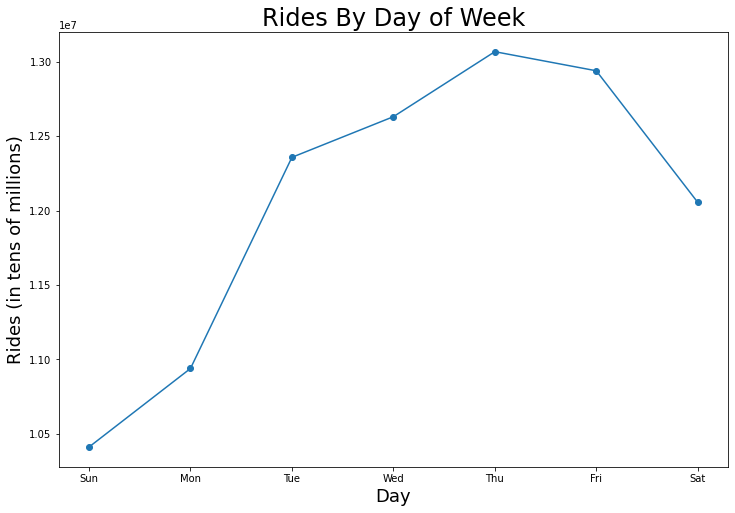

In [38]:
# DAYofWEEK
## Visualizations
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
ax.plot(dow_2019_df['Day of Week'], dow_2019_df['Count'], marker = 'o')
plt.title('Rides By Day of Week', fontsize=24)
plt.xlabel('Day', fontsize=18)
plt.ylabel('Rides (in tens of millions)', fontsize=18)
plt.show()

## 2.C Rides by Hour of the Day<a name="API_hod">

In [39]:
# Instance by HOURofDAY
# Hours 00 to 23

# SoQL Query
instances_hh_q = '''
SELECT
    date_extract_hh(tpep_pickup_datetime), COUNT(*)
GROUP BY
    date_extract_hh(tpep_pickup_datetime)
'''
print(f'SoQL Query:\n{instances_hh_q}')
# instances_hh_r = client.get(data_set_ids_dict['Yellow'][2019], query = instances_hh_q)

# ## Add Counts from DB to DataFrame
# hours_2019_df = pd.DataFrame.from_dict(instances_hh_r).rename(columns={"COUNT": "Count"})
# ## Add Hours
# hours_2019_df['Hour'] = np.arange(24)
# ## Make Sure dtypes are int
# hours_2019_df['Count'] = hours_2019_df['Count'].astype(int)
# ## To CSV
# hours_2019_df.to_csv('2019_Rides_Hour.csv')
# ## Read CSV
hours_2019_df = pd.read_csv('2019_Rides_Hour.csv')

SoQL Query:

SELECT
    date_extract_hh(tpep_pickup_datetime), COUNT(*)
GROUP BY
    date_extract_hh(tpep_pickup_datetime)



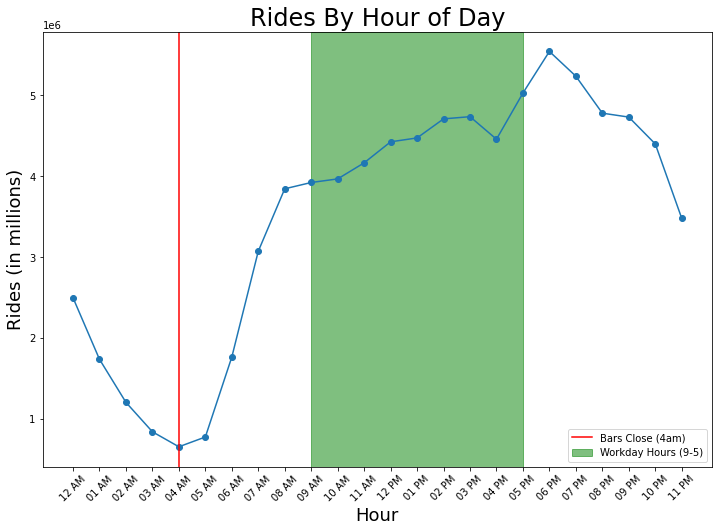

In [40]:
# Instance by HOURofDAY
## Visualizations
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
ax.plot(range(24), hours_2019_df.groupby('Hour')['Count'].sum(), marker = 'o')
ax.axvspan(9, 17, alpha=0.5, color='green', label = 'Workday Hours (9-5)')
ax.axvline(x=4, color = 'red', label = 'Bars Close (4am)') # Officially, bars in New York City close at 4 am
plt.title('Rides By Hour of Day', fontsize=24)
plt.xlabel('Hour', fontsize=18)
plt.ylabel('Rides (in millions)', fontsize=18)
plt.xticks(range(24), labels = pd.date_range(start='1/1/2019', periods=24, freq='H').strftime('%I %p'), rotation = 45)
plt.legend()
plt.show()

### Rides by Hour of Day by Day of Week

In [41]:
# Instance by HOURofDAY by DAYofWEEK
# Hours 00 to 23
# SoQL Query
instances_hhdow_q = '''
SELECT
    date_extract_hh(tpep_pickup_datetime), date_extract_dow(tpep_pickup_datetime), COUNT(*)
GROUP BY
    date_extract_dow(tpep_pickup_datetime), date_extract_hh(tpep_pickup_datetime)
'''
print(f'SoQL Query:\n{instances_hhdow_q}')
# instances_hhdow_r = client.get(data_set_ids_dict['Yellow'][2019], query = instances_hhdow_q)

# ## Add Counts from DB to DataFrame
# hours_2019_df = pd.DataFrame.from_dict(instances_hhdow_r).rename(columns={"COUNT": "Count", 'date_extract_dow_tpep_pickup_datetime': 'Day', 'date_extract_hh_tpep_pickup_datetime': 'Hour'})
# ## Add Hours
# #hours_2019_df['Hour'] = np.arange(24)
# ## Make Sure dtypes are int
# hours_2019_df = hours_2019_df.astype(int)
# ## To CSV
# hours_2019_df.to_csv('2019_Rides_Hour.csv')
## Read CSV
hours_2019_df = pd.read_csv('2019_Rides_Hour.csv')

SoQL Query:

SELECT
    date_extract_hh(tpep_pickup_datetime), date_extract_dow(tpep_pickup_datetime), COUNT(*)
GROUP BY
    date_extract_dow(tpep_pickup_datetime), date_extract_hh(tpep_pickup_datetime)



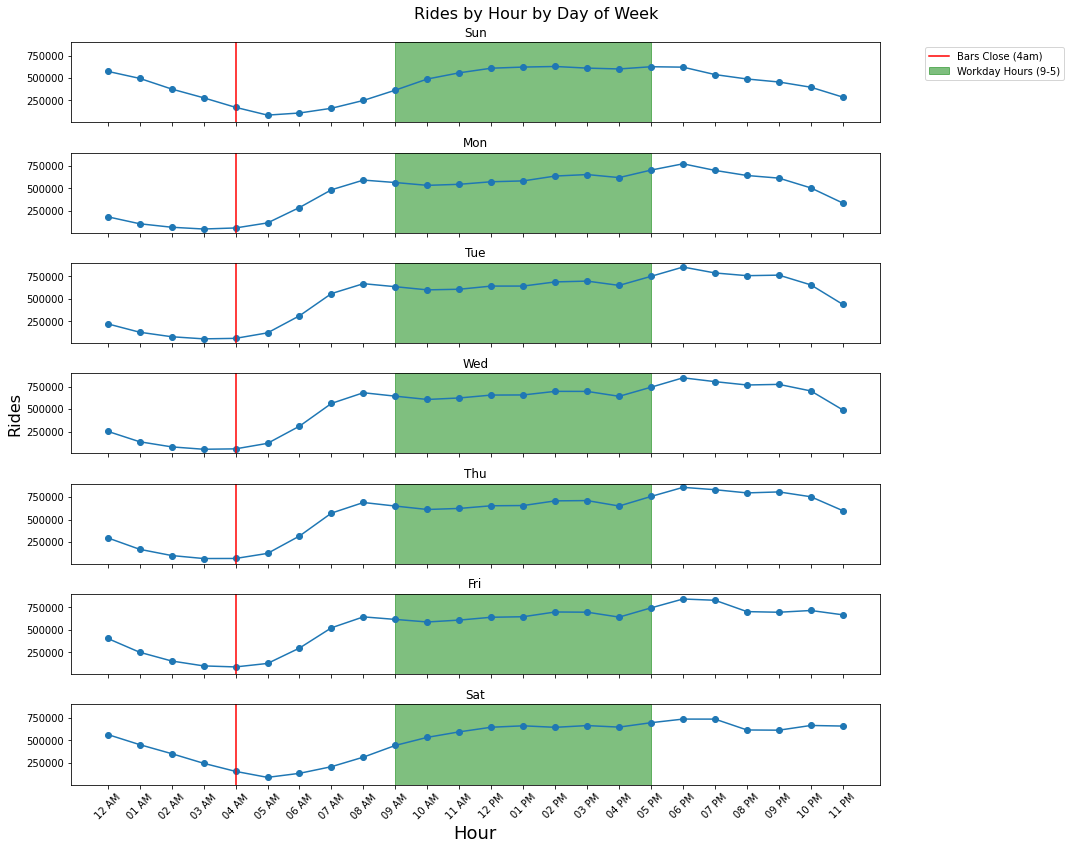

In [42]:
# Instance by HOURofDAY by DAYofWEEK
## Visualizations
fig, ax = plt.subplots(nrows = 7, ncols = 1, sharex = True, sharey = True,figsize=(15, 12), tight_layout=True)
for i in range(7):
    ax[i].plot(hours_2019_df[hours_2019_df.Day == i]['Hour'], hours_2019_df[hours_2019_df.Day == i]['Count'], marker = 'o')
    ax[i].set(title = dow_2019_l[i])
    ax[i].axvspan(9, 17, alpha=0.5, color='green', label = 'Workday Hours (9-5)')
    ax[i].axvline(x=4, color = 'red', label = 'Bars Close (4am)') # Officially, bars in New York City close at 4 am
    if i == 0:
        ax[i].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    if i == 3:
        ax[i].set_ylabel('Rides', fontsize = 16)
#plt.title('Rides By Hour of Day', fontsize=24)
plt.xlabel('Hour', fontsize=18)
plt.xticks(range(24), labels = pd.date_range(start='1/1/2019', periods=24, freq='H').strftime('%I %p'), rotation = 45)
fig.suptitle('Rides by Hour by Day of Week', fontsize = 16)
plt.show()

It looks like Saturday early am (i.e., Friday late night) and Sunday early am (i.e., Saturday late night) are the only days where the lowest number of rides is after 4am: Apparently people stay right up until the bar closes!

### Rides by Hour of Day: Weekday vs Weekend

Text(0.5, 1.0, 'Average Rides by Hour: Weekend vs Weekday')

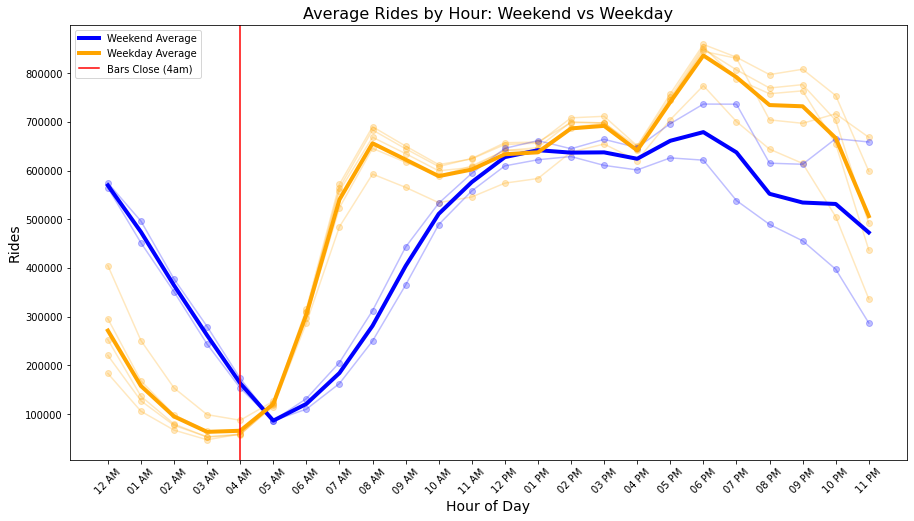

In [43]:
# Instance by HOURofDAY by DAYofWEEK (Weekend vs Weekday)
fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(111)
color_dow_dict = {'Weekend': 'blue', 'Weekday': 'orange'}

for i in range(7):
    if i in [0,6]:
        color = 'blue'
    else:
        color = 'orange'
    ax.plot(hours_2019_df[hours_2019_df.Day == i]['Hour'], hours_2019_df[hours_2019_df.Day == i]['Count'], marker = 'o', color = color, alpha = 0.25)

# Weekend and Weekday Means
ax.plot(hours_2019_df[hours_2019_df.Day.isin([0,6])].groupby('Hour').mean().index,hours_2019_df[hours_2019_df.Day.isin([0,6])].groupby('Hour').mean()['Count'], color = color_dow_dict['Weekend'], linewidth=4, label = 'Weekend Average')
ax.plot(hours_2019_df[~hours_2019_df.Day.isin([0,6])].groupby('Hour').mean().index,hours_2019_df[~hours_2019_df.Day.isin([0,6])].groupby('Hour').mean()['Count'], color = color_dow_dict['Weekday'], linewidth=4, label = 'Weekday Average')
plt.xticks(range(24), labels = pd.date_range(start='1/1/2019', periods=24, freq='H').strftime('%I %p'), rotation = 45)
plt.xlabel("Average Rides by Hour: Weekend vs Weekday", fontsize = 14)
plt.ylabel("Rides", fontsize = 14)
ax.axvline(x=4, color = 'red', label = 'Bars Close (4am)')
plt.xticks(range(24), labels = pd.date_range(start='1/1/2019', periods=24, freq='H').strftime('%I %p'), rotation = 45)
plt.xlabel("Hour of Day", fontsize = 14)
plt.ylabel("Rides", fontsize = 14)
plt.legend()
plt.title("Average Rides by Hour: Weekend vs Weekday", fontsize = 16)

## Feature Relations<a name="API_hod">
The Socrata API allows for some statistics to be queried from the full dataset:
- the population average of a feature;
- the population standard deviation of a feature;
- the y-intercept of a linear least squares fit of two features;
- the slope of the linear least squares fit;
- the square of the correlation coefficient ($r^2$).

We give one example of a query that regresses tip amount on trip distance.

In [44]:
# Tip and Distance regr_slope(field_y, field_x)
tip_distance_q = '''
SELECT
   regr_intercept(tip_amount, trip_distance), regr_slope(tip_amount, trip_distance)
WHERE
   tip_amount >0
   AND trip_distance >0
'''
print(f'SoQL Query:\n{tip_distance_q}')
# tip_distance_r = client.get(data_set_ids_dict['Yellow'][2019], query = tip_distance_q)
# # Pickle
# ## Save
# f = open('tip_distance_r.pkl', 'wb')
# pickle.dump(tip_distance_r, f, -1)
# f.close()
# Open
f = open('tip_distance_r.pkl', 'rb')
tip_distance_r = pickle.load(f)     
f.close()

SoQL Query:

SELECT
   regr_intercept(tip_amount, trip_distance), regr_slope(tip_amount, trip_distance)
WHERE
   tip_amount >0
   AND trip_distance >0



In [45]:
print(f"We can regress tip amount on trip distance using the API.\nThe regression intercept is {np.round(float(tip_distance_r[0]['regr_intercept_tip_amount_trip_distance']),2)} and the slope is {np.round(float(tip_distance_r[0]['regr_slope_tip_amount_trip_distance']),2)}.\nFor every mile driven, the tip goes up about 50 cents.")

We can regress tip amount on trip distance using the API.
The regression intercept is 1.46 and the slope is 0.56.
For every mile driven, the tip goes up about 50 cents.


This population level of analysis uses the full dataset, but is quite limited. To get more a more detailed look at the relations among the features, we thus had to work from a sample of the full data set.

# <center>3. 2019 Yellow Taxi Dataset with `datatable`<a name="DT_describe"></a></center>
The Socrata API limits results to 1000 instances. Although stratified sampling would be possible, the number of calls required would take a good deal of time and risk data throttling. Nevertheless, the full csv, though downloadable, contains ~84 million instances and is over 8G. We therefore decided to work directly with the full data via the `datatable` package to obtain a stratified sample of the data, balanced by proportion of rides by hour for each day of the year, with every hour getting at least 1 sampled ride, for a total of ~180k instances.  
datatable: https://datatable.readthedocs.io/en/latest/



*The sampling via `datatable` has been commented out since it requires the full dataset.*

## 3.A Packages <a name="packages2"></a>

In [46]:
import datatable as dt
from datatable import (f, by, ifelse, update, sort, count)

### Download Full Dataset as CSV

In [47]:
# Download Full CSV (> 8G) to Current WD
# Site Link:
## https://data.cityofnewyork.us/Transportation/2019-Yellow-Taxi-Trip-Data/2upf-qytp
# Download Link:
## https://data.cityofnewyork.us/api/views/2upf-qytp/rows.csv?accessType=DOWNLOAD
# ! curl -o NYC_2019_Yellow_Taxi_Trip_Data.csv https://data.cityofnewyork.us/api/views/2upf-qytp/rows.csv?accessType=DOWNLOAD

In [48]:
# Load in CSV as datatable
#Y_Taxi_2019_dt = dt.fread("NYC_2019_Yellow_Taxi_Trip_Data.csv")

### Features and DataTypes

In [49]:
#pd.DataFrame(zip(Y_Taxi_2019_dt.names, Y_Taxi_2019_dt.stypes), columns = ['Feature', 'DataType'])

### Features Pruning

From the Socrata metadata, we know these features have nulls from the metadata:

`VendorID`  
`passenger_count`  
`RatecodeID`  
`store_and_fwd_flag`  
`payment_type`  
`congestion_surcharge`.

To improve processing, we eliminate as many as possible. Of these, we will keep only `passenger_count`, `payment_type`, and `RatecodeID`.

In [50]:
#col_nulls = ['VendorID', 'store_and_fwd_flag', 'congestion_surcharge'] # Keep 'passenger_count', 'payment_type', 'RatecodeID'
#del Y_Taxi_2019_dt[:, col_nulls]

In [51]:
#instances_ct_original = Y_Taxi_2019_dt.shape[0]
#print(f'As above from the API, our full dataset has {instances_ct_original} instances prior to cleaning.')

## 3.B. Data Cleaning from MetaData<a name="DT_clean1"></a>
The explorations of the full dataset via the API allowed us to make data cleaning decisions on some features: `Passenger_count `; `RateCodeID`; and `Payment_type `.
### Data Cleaning from MetaData: `passenger_count `
We eliminate those instances where `passenger_count ` = 0 or `passenger_count ` > 6.

In [52]:
#del Y_Taxi_2019_dt[(f.passenger_count == 0) | (f.passenger_count > 6), :]

### Data Cleaning from MetaData: `RatecodeID`
We eliminate those instances where `RatecodeID` $\in \{3,4,5\}$.

In [53]:
#del Y_Taxi_2019_dt[f.RatecodeID >= 3, :]

### Data Cleaning from MetaData: `payment_type `
We eliminate those instances where `payment_type` is not either credit card (1) or cash (2).

In [54]:
#del Y_Taxi_2019_dt[f.payment_type >2, :]

In [55]:
#print(f'After this first round of cleaning based on the metadata, our dataset has {Y_Taxi_2019_dt.shape[0]} instances. This is {np.round(Y_Taxi_2019_dt.shape[0]/instances_ct_original, 2)} of the data.')

## 3.C Feature Creation:  Stratum for Sample<a name="DT_stratum"></a>
We consider the **stratum** for our sample as each **hour** of the year.  
The csv returns the date and time as a string. We separate this string into its components to create a unique Month-Day-Hour (`MDh`) for each pick-up time. We assume years in the data that are not 2019 are typos for 2019, so we allow, say, both 10/20/2019 and 10/20/2009 to count as 10/20.

In [56]:
# Month-Day-hour from 
#Y_Taxi_2019_dt['M'] = f.tpep_pickup_datetime[0:2]
#Y_Taxi_2019_dt['D'] = f.tpep_pickup_datetime[3:5]
#Y_Taxi_2019_dt['H'] = f.tpep_pickup_datetime[11:13]
# Change AM/PM into 24 hour clock
#Y_Taxi_2019_dt['AMPM'] = f.tpep_pickup_datetime[20:]
#Y_Taxi_2019_dt['H'] = dt.Type.int32
#Y_Taxi_2019_dt['h'] = ifelse(((f.AMPM == 'AM') & (f.H == 12)), 0,
#                             f.AMPM == 'PM', f.H + 12, f.H)
#Y_Taxi_2019_dt['h'] = dt.Type.str32 # Return hour to string
# Create MD and MDh features
#Y_Taxi_2019_dt['MD'] = f.M + '_' + f.D
#Y_Taxi_2019_dt['MDh'] = f.M + '_' + f.D + '_' + f.h

To determine the stratum size as the proportion of the population for each `MDh`, we create a count of rides for each stratum and we determine the total population size (i.e., total number if rides).

In [57]:
# Rides for Each Hour of Each Day of the Year
#Y_Taxi_2019_dt[:, update(MDh_count = count()), by('MDh')]
# Total Number of Rides (Population size for proportional sampling)
#Y_Taxi_2019_dt.shape[0]

## 3.D Data Cleaning: Pre-Sample<a name="DT_clean2"></a>
The `pandas` package provides more flexibility than `datatable` for describing and cleaning data. Nevertheless, any cleaning of the data we can do prior to the sample will preserve the most data possible.

### Data Cleaning: Dates
We know that there are typos for the year, which we ignore. What about the months and days?  
We exepct 12 months:

In [58]:
#Y_Taxi_2019_dt['M'].nunique()

We expect 24 hours:

In [59]:
#Y_Taxi_2019_dt['h'].nunique()

We expect 365 unique month-day combinations, i.e., days of the year:

In [60]:
#Y_Taxi_2019_dt['MD'].nunique()

366 days only occur in a leap-year, and 2019 was not one. We look to see if Feb 29 is in the data:

In [61]:
#Y_Taxi_2019_dt[(f.M == '02') & (f.D == '29'), :]

These seven rides were misrecorded. Unilke the typos for year, we cannot tell where the 02/29 rides should go. But there are only 7, each with 2 or 1 rides (`MDh_count`), so we delete them. The fewest rides for any other hour of any other day is 499.

In [62]:
#del Y_Taxi_2019_dt[(f.M == '02') & (f.D == '29'), :]

Now we have 365 days:

In [63]:
#Y_Taxi_2019_dt['MD'].nunique()

Total number of MDh-strata:

In [64]:
#Y_Taxi_2019_dt['MDh'].nunique()

### Data Cleaning: `trip_distance`
Any trip with distance equal to 0 is eliminated.

In [65]:
#del Y_Taxi_2019_dt[f.trip_distance == 0, :]

In the metadata above we also notice that there are negative distances.

In [66]:
#Y_Taxi_2019_dt[f.trip_distance < 0, :].shape

Since they are few and probably typos, we could either eliminate them or make them positive, under the assumption that the negative sign is the error. But rather than make this assumption, we eliminate the few instances where trips were of negative distance.

In [67]:
#del Y_Taxi_2019_dt[f.trip_distance < 0, :]

In [68]:
#distance_a = Y_Taxi_2019_dt['trip_distance'].to_pandas()
#distance_a.describe()

There are still trips over 800 miles, i.e., the distance to Atlanta (GA) or Springfield (IL). It is 225 miles from NYC to Washington DC or Boston. We eliminate all trips over 250 miles.

In [69]:
#del Y_Taxi_2019_dt[f.trip_distance > 250, :]

### Data Cleaning: Fare Amount
The minimum fare in NYC is $2.50. We first eliminate any instance where the fare is below this number. (There are no null values in this feature, but there are values equal to 0.)

In [70]:
#del Y_Taxi_2019_dt[(f.fare_amount < 2.5), :]

Are there values that are too high?

In [71]:
#Y_Taxi_2019_dt['fare_amount'].max()

How could this trip cost so much? Even if there is a misplaced decimal, the fare is unbelievable. We look at this ride:

In [72]:
#Y_Taxi_2019_dt[(f.fare_amount == Y_Taxi_2019_dt['fare_amount'].max()), :]

In [73]:
#fare_a = Y_Taxi_2019_dt['fare_amount'].to_pandas()
#fare_a.describe()

In [74]:
#print(f'As there are only {Y_Taxi_2019_dt[(f.fare_amount > 500), :].shape[0]} rides where the fare is over USD500, we remove them.')

In [75]:
#del Y_Taxi_2019_dt[(f.fare_amount > 500), :]

In [76]:
#print(f'After this second round of cleaning, our dataset has {Y_Taxi_2019_dt.shape[0]} instances. This is {np.round(Y_Taxi_2019_dt.shape[0]/instances_ct_original,2)} of the data.')

##  <center>4. Stratified Sampling (Proportional Allocation)<a name="DT_sample"></a>
### Strata Proportions
We create a sample that takes the smallest stratum and gives it a size of 1, $n_h = 1$:

In [77]:
# datatable with strata information
#prop_MDh_dt = Y_Taxi_2019_dt[:, count(f.MDh), by('MDh')]
#prop_MDh_dt.names = ['MDh', 'MDh_Count']
#rides_N = Y_Taxi_2019_dt.shape[0]
#prop_MDh_dt['Prop'] = f.MDh_Count / rides_N
#sample_n = np.ceil(1/prop_MDh_dt['Prop'].min()[0,0]) # smallest stratum given 1
#prop_MDh_dt['Sample'] = dt.math.ceil(f.Prop * sample_n)
#prop_MDh_dt['Sample'] = dt.Type.int32
#prop_MDh_dt.head(10)

We check to make sure that the proportions add to 1.

In [78]:
# Proportions should add to 1
#prop_MDh_dt[:, 'Prop'].sum()

The **minimum stratum size** will determine the minimum size of our sample, since we want each stratum to have at least one sample ($n_{sample} \geq 1$).

In [79]:
# minimum stratum size, for which sample size >= 1
#prop_MDh_dt[:, 'MDh_Count'].min()

In [80]:
#stratum_min_date = pd.to_datetime('2019_' + prop_MDh_dt[f.MDh_Count == prop_MDh_dt[:, 'MDh_Count'].min()[0,0], 0][0,0], format = '%Y_%m_%d_%I')
#print(f"The lowest MDh being {stratum_min_date.strftime('%d %B')} at {stratum_min_date.strftime('%r')}.")

In [81]:
#prop_MDh_dt[f.MDh_Count == prop_MDh_dt[:, 'MDh_Count'].min()[0,0], :]

### Sampling Index

In [82]:
# Sort the datatables by Month-Day-hour (MDh) to match
#Y_Taxi_2019_dt = Y_Taxi_2019_dt[:, :, sort(f.MDh)]
#prop_MDh_dt = prop_MDh_dt[:,:, sort(f.MDh)]

In [83]:
# Set Random Seed
#rng = np.random.default_rng(seed = 1007) 
# Sampling Index
#sampling_l = []
#prop_MDh_dt['Sample'] = dt.Type.int32
# start_time = time.time()
#for i in range(prop_MDh_dt.shape[0]): # Unit Test range(3)
#    sampling_l.extend(rng.choice(range(int(prop_MDh_dt[0:i,'MDh_Count'].sum()[0,0]), int(prop_MDh_dt[0:(i+1),'MDh_Count'].sum()[0,0])), size = prop_MDh_dt[i, 'Sample'], replace = False, shuffle = False))
# print(time.time() - start_time)

In [84]:
# Length of Sample
#print(f'The sample size is {len(sampling_l)}.')

### Sample Creation

In [85]:
# Sampled datatable
#Y_Taxi_2019_SAMPLE_dt = Y_Taxi_2019_dt[sampling_l, :]
#Y_Taxi_2019_SAMPLE_dt.shape

We ask whether the stratum size in the sample is as intended:

In [86]:
# datatable with strata information
#prop_MDh_SAMPLE_dt = Y_Taxi_2019_SAMPLE_dt[:, count(f.MDh), by('MDh')]
#prop_MDh_SAMPLE_dt.names = ['MDh_sample', 'MDh_sample_Count']
#prop_MDh_SAMPLE_dt = prop_MDh_SAMPLE_dt[:,:,sort(f.MDh_sample)]
#prop_MDh_dt.cbind(prop_MDh_SAMPLE_dt)
#prop_MDh_dt.head()

In [87]:
#prop_MDh_dt['Same'] = (f.Sample == f.MDh_sample_Count)
#prop_MDh_dt[:, 'Same'].sum()[0,0] == Y_Taxi_2019_dt[:, count(f.MDh), by('MDh')].shape[0]

In [86]:
# Write to CSV
# Y_Taxi_2019_SAMPLE_dt.to_csv("Yellow_Taxi_2019_sample.csv")

## <center>5. Sample Features<a name="Sample_Analysis"></a></center>

### Sample Features

In [87]:
# For description and analyses we use pandas
## From datatable
# data = Y_Taxi_2019_SAMPLE_dt.to_pandas()
# data.tpep_pickup_datetime = pd.to_datetime(data.tpep_pickup_datetime)
# data.tpep_dropoff_datetime = pd.to_datetime(data.tpep_dropoff_datetime)
## Fron CSV
data = pd.read_csv("Yellow_Taxi_2019_sample.csv", parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,...,improvement_surcharge,total_amount,M,D,H,AMPM,h,MD,MDh,MDh_count
0,2019-01-01 00:49:15,2019-01-01 00:54:29,1.0,1.10,1.0,263,140,1.0,6.0,0.5,...,0.3,8.30,1,1,12,AM,0,01_01,01_01_0,13441
1,2019-01-01 00:41:13,2019-01-01 00:52:04,1.0,0.84,1.0,234,234,2.0,8.0,0.5,...,0.3,9.30,1,1,12,AM,0,01_01,01_01_0,13441
2,2019-01-01 00:45:40,2019-01-01 00:50:57,1.0,0.93,1.0,79,137,1.0,5.5,0.5,...,0.3,6.80,1,1,12,AM,0,01_01,01_01_0,13441
3,2019-01-01 00:12:50,2019-01-01 00:37:00,1.0,4.53,1.0,162,24,1.0,19.0,0.5,...,0.3,24.36,1,1,12,AM,0,01_01,01_01_0,13441
4,2019-01-01 00:54:03,2019-01-01 01:31:02,2.0,5.34,1.0,211,142,1.0,25.5,0.5,...,0.3,32.16,1,1,12,AM,0,01_01,01_01_0,13441


In [88]:
data.shape

(177714, 23)

In [89]:
data.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
payment_type                    float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
M                                 int64
D                                 int64
H                                 int64
AMPM                             object
h                                 int64
MD                               object
MDh                              object
MDh_count                         int64
dtype: object

## 5.A Feature Creation: `trip_duration` (Travel Time in Minutes)<a name="TT_min">

In [90]:
data['trip_duration'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime'])
data['trip_duration'] = data['trip_duration'].dt.total_seconds()/60
data['trip_duration'].describe()

count    177714.000000
mean         17.940570
std          69.805875
min           0.000000
25%           6.816667
50%          11.366667
75%          18.583333
max        1439.316667
Name: trip_duration, dtype: float64

In [91]:
print(f"We notice that there are negative values, meaning the trip finished before it began! Clearly an error. The largest trip also took {data['trip_duration'].describe()['max']}, or {data['trip_duration'].describe()['max']/60} hours, almost a full day. Probably an error as well.")

We notice that there are negative values, meaning the trip finished before it began! Clearly an error. The largest trip also took 1439.3166666666666, or 23.98861111111111 hours, almost a full day. Probably an error as well.


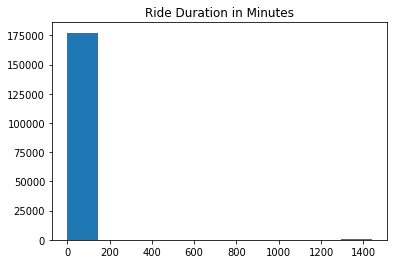

In [92]:
plt.hist(data['trip_duration'])
plt.title('Ride Duration in Minutes')
plt.show()

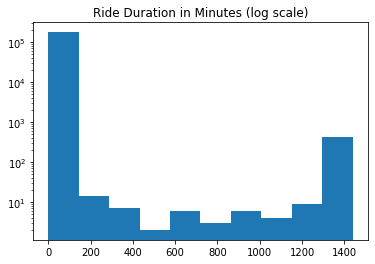

In [93]:
plt.hist(data['trip_duration'], log = True)
plt.title('Ride Duration in Minutes (log scale)')
plt.show()

The prevalence of rides lasting longer than 1300 minutes indicates some sort of **systematic error** in reporting pickup and dropoff times. Otherwise, we expect the logarithmic distribution shown.

## 5.B Feature Creation: `speed` (Average Travel Speed)<a name="speed">
Since we have trip distance and now trip duration (in minutes) we can calculate the trip speed in miles per hour (mph).

In [94]:
data['speed'] = (data['trip_distance']/data['trip_duration']) * 60
data.speed.describe()

count    1.777140e+05
mean              inf
std               NaN
min      9.176544e-03
25%      7.252427e+00
50%      9.818182e+00
75%      1.347289e+01
max               inf
Name: speed, dtype: float64

We note that there was a problem with this feature creation: Since there are null and infinite values. We suspect that some `trip_duration` values are 0, i.e., the recorded trip pickup and dropoff timestamps were identical.

In [95]:
print(f'There are {data[data.trip_duration == 0].shape[0]} instances where trip duration is 0.')

There are 4 instances where trip duration is 0.


In [96]:
data = data[data.trip_duration > 0]
data.shape

(177710, 25)

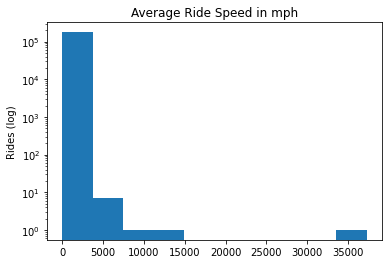

In [97]:
plt.hist(data['speed'], log = True)
plt.title('Average Ride Speed in mph')
plt.ylabel('Rides (log)')
plt.show()

In [98]:
data.speed.describe()

count    177710.000000
mean         12.182768
std         106.273261
min           0.009177
25%           7.252359
50%           9.818182
75%          13.472393
max       37260.000000
Name: speed, dtype: float64

Somehow there are speeds well in excess not only of the speed limit but of the possible speed of modern planes!  
The NYC citywide maximum speed limit is 25 mph unless otherwise posted.

In [99]:
print(f"There were {len(data[data.speed > 25])} rides recorded as being over the NYC speed limit. But of those, {len(data[data.speed > 80])} were recorded as above 80mph, probably indicating an error.")

There were 7510 rides recorded as being over the NYC speed limit. But of those, 89 were recorded as above 80mph, probably indicating an error.


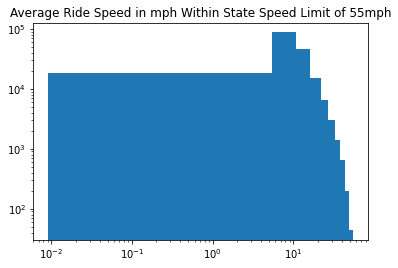

In [100]:
plt.hist(data[data.speed <= 55].speed, log = True)
plt.title('Average Ride Speed in mph Within State Speed Limit of 55mph')
plt.xscale('log')
plt.show()

In [101]:
print(f"We see the median speed, {data[data.speed <= 55].speed.describe()['50%']}mph, and average speed, {data[data.speed <= 55].speed.describe()['mean']}mph, of NYC Yellow taxi rides.")

We see the median speed, 9.811951834846354mph, and average speed, 11.264787284853131mph, of NYC Yellow taxi rides.


### Log-Scale Histograms
We define a function to produce a histogram where the bins are logarithmically distributed.

In [102]:
def plot_loghist(x, bins = 100): 
    logbins = np.logspace(np.log10(x.min()),np.log10(x.max()),bins)
    plt.hist(x, bins=logbins)
    plt.xscale('log')

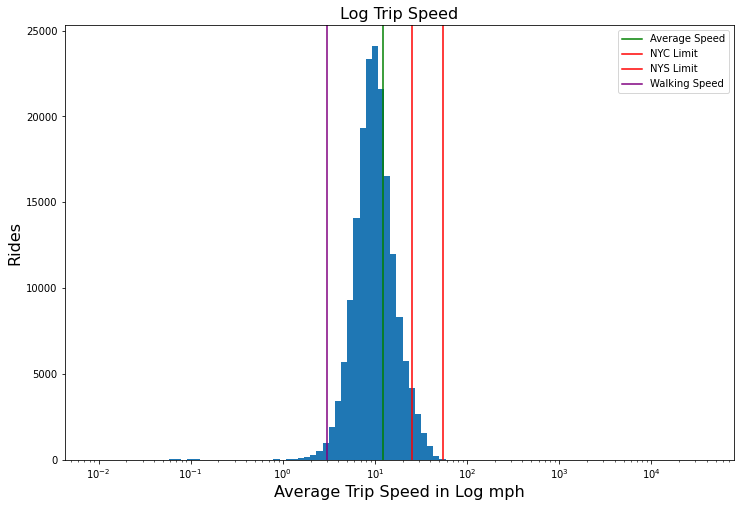

In [103]:
plt.figure(figsize=(12,8))
plot_loghist(data.speed, 100)
plt.title('Log Trip Speed', fontsize = 16)
plt.ylabel('Rides', fontsize = 16)
plt.xlabel('Average Trip Speed in Log mph', fontsize = 16)
plt.axvline(x=data.speed.mean(), color = 'green', label = 'Average Speed')
plt.axvline(x=25, color = 'red', label = 'NYC Limit')
plt.axvline(x=55, color = 'red', label = 'NYS Limit')
plt.axvline(x=3, color = 'purple', label = 'Walking Speed')
plt.legend()
plt.show()

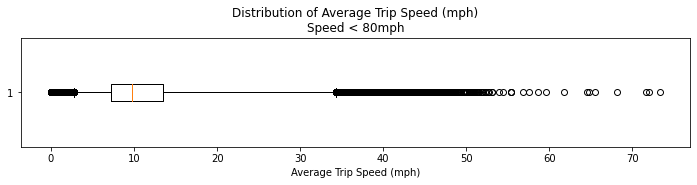

In [104]:
# Box Plot of average Speed
plt.figure(figsize=(12,2))
plt.boxplot(data[data.speed <= 80].speed, whis=[1, 99], vert = False) #1st and 99th percentiles and the outliers beyond them
plt.title('Distribution of Average Trip Speed (mph)\nSpeed < 80mph')
plt.xlabel("Average Trip Speed (mph)")
plt.show()

In [105]:
print(f"Adults walk at an average speed of 3 to 4 miles per hour; in our sample there are {len(data[data.speed <= 4])} trips slower than an average walk.\nHey, maybe it beats walking!")

Adults walk at an average speed of 3 to 4 miles per hour; in our sample there are 6194 trips slower than an average walk.
Hey, maybe it beats walking!


## Feature Description: `trip_distance` (Trip Distance)

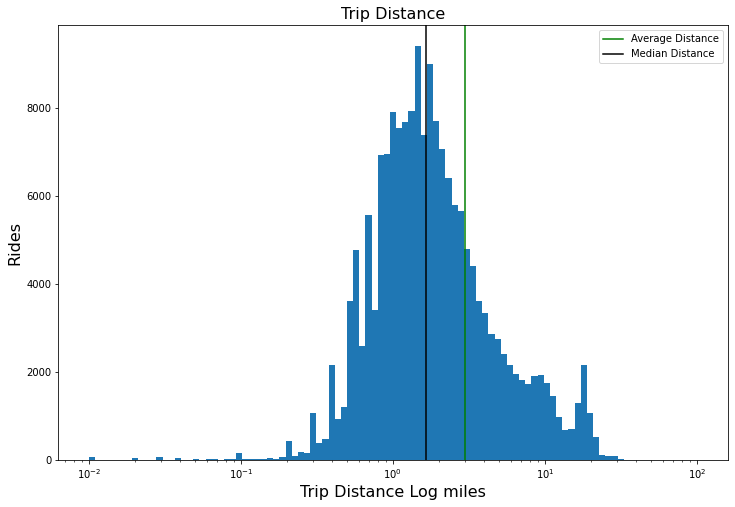

In [106]:
plt.figure(figsize=(12,8))
plot_loghist(data.trip_distance)
plt.title('Trip Distance', fontsize = 16)
plt.ylabel('Rides', fontsize = 16)
plt.xlabel('Trip Distance Log miles', fontsize = 16)
plt.axvline(x=data.trip_distance.mean(), color = 'green', label = 'Average Distance')
plt.axvline(x=data.trip_distance.median(), color = 'black', label = 'Median Distance')
plt.legend()
plt.show()

While most trips are short, several longer trips skew the average. We us a box plot to get a sence of the Inter-Quartile Range around this median.

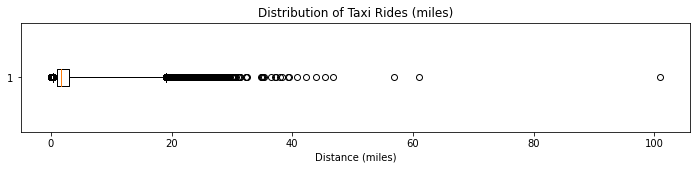

In [107]:
# Box Plot of average Distance
plt.figure(figsize=(12,2))
plt.boxplot(data.trip_distance, whis=[1, 99], vert = False) #1st and 99th percentiles and the outliers beyond them
plt.title('Distribution of Taxi Rides (miles)')
plt.xlabel("Distance (miles)")
plt.show()

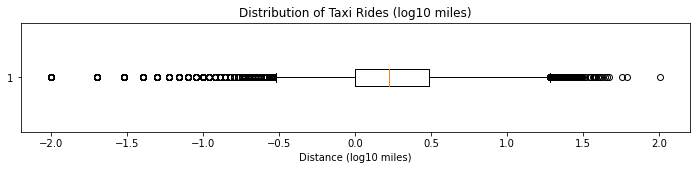

In [108]:
# Box Plot of average Distance
plt.figure(figsize=(12,2))
plt.boxplot(np.log10(data.trip_distance), whis=[1, 99], vert = False) #1st and 99th percentiles and the outliers beyond them
plt.title('Distribution of Taxi Rides (log10 miles)')
plt.xlabel("Distance (log10 miles)")
plt.show()

In [109]:
print(f"Quantiles above tells us that 98% of the trips are betweem {data.trip_distance.quantile(0.01)} to {data.trip_distance.quantile(0.99)} miles. Some are too short (<0.3 mile) while others are too long. Maybe, trips over 20 miles are still possible. The full dataset indicates a ride that was 45977.22 miles, an absurd figure (well beyond the driving distance between Staten Island, north Bronx or EWR (included in the analysis) and JFK or Far Rockaways, which is around 40miles!).\nThe longest trip in our samepl is {data.trip_distance.describe()['max']} miles, and there are only {len(data[data.trip_distance > 40])} trips in our sample above 40 miles.")

Quantiles above tells us that 98% of the trips are betweem 0.3 to 19.04 miles. Some are too short (<0.3 mile) while others are too long. Maybe, trips over 20 miles are still possible. The full dataset indicates a ride that was 45977.22 miles, an absurd figure (well beyond the driving distance between Staten Island, north Bronx or EWR (included in the analysis) and JFK or Far Rockaways, which is around 40miles!).
The longest trip in our samepl is 100.9 miles, and there are only 8 trips in our sample above 40 miles.


## Feature Description: `trip_duration` (Trip Duration)

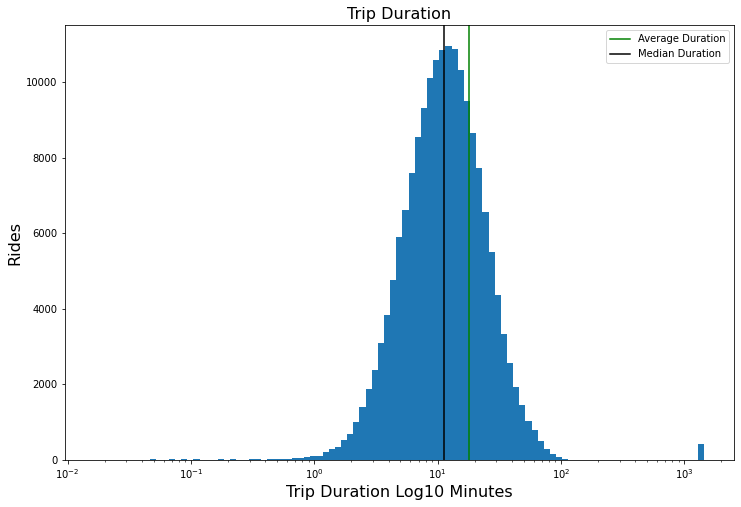

In [110]:
plt.figure(figsize=(12,8))
plot_loghist(data.trip_duration)
plt.title('Trip Duration', fontsize = 16)
plt.ylabel('Rides', fontsize = 16)
plt.xlabel('Trip Duration Log10 Minutes', fontsize = 16)
plt.axvline(x=data.trip_duration.mean(), color = 'green', label = 'Average Duration')
plt.axvline(x=data.trip_duration.median(), color = 'black', label = 'Median Duration')
plt.legend()
plt.show()

In [111]:
print(f"The shortest trip took {np.round(data.trip_duration.describe()['min'], 2)} minutes; the longest {data.trip_duration.describe()['max']} minutes, which is {np.round(data.trip_duration.describe()['max']/60, 2)} hours, almost 1 day! Clearly an error.")

The shortest trip took 0.02 minutes; the longest 1439.3166666666666 minutes, which is 23.99 hours, almost 1 day! Clearly an error.


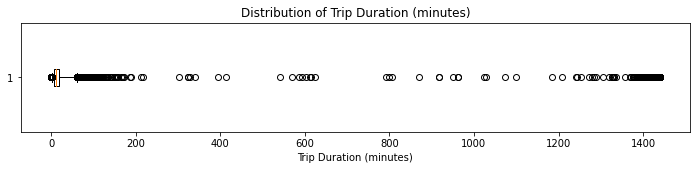

In [112]:
# Box Plot of Duration
plt.figure(figsize=(12,2))
plt.boxplot(data.trip_duration, whis=[1, 99], vert = False) #1st and 99th percentiles and the outliers beyond them
plt.title('Distribution of Trip Duration (minutes)')
plt.xlabel("Trip Duration (minutes)")
plt.show()

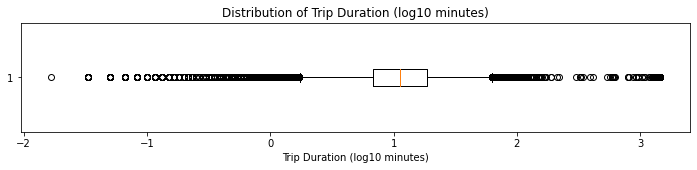

In [113]:
# Box Plot of Duration
plt.figure(figsize=(12,2))
plt.boxplot(np.log10(data.trip_duration), whis=[1, 99], vert = False) #1st and 99th percentiles and the outliers beyond them
plt.title('Distribution of Trip Duration (log10 minutes)')
plt.xlabel("Trip Duration (log10 minutes)")
plt.show()

## Feature Description: `fare_amount` (Fare Amount)

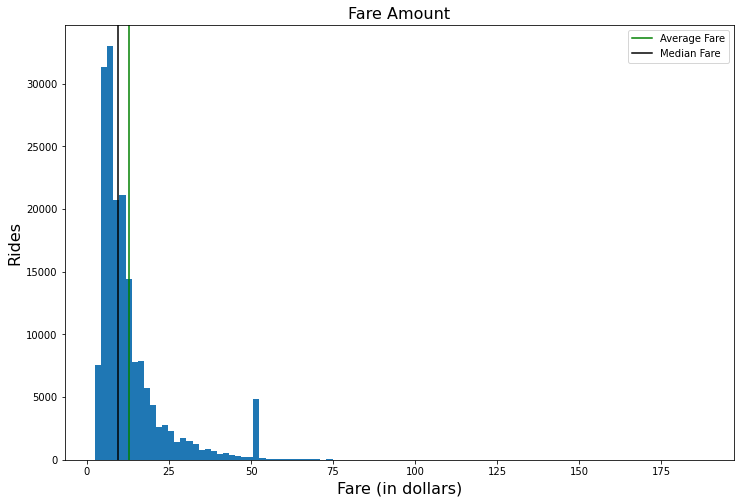

In [114]:
plt.figure(figsize=(12,8))
plt.hist(data.fare_amount, bins = 100)
plt.title('Fare Amount', fontsize = 16)
plt.ylabel('Rides', fontsize = 16)
plt.xlabel('Fare (in dollars)', fontsize = 16)
plt.axvline(x=data.fare_amount.mean(), color = 'green', label = 'Average Fare')
plt.axvline(x=data.fare_amount.median(), color = 'black', label = 'Median Fare')
plt.legend()
plt.show()

In [115]:
print(f"While most fares are below ${data.fare_amount.describe()['50%']}, we note that the maximum fare recorded in our sample is ${data.fare_amount.describe()['max']}.\nThere is also an unexpected bump at about 50, perhaps due to the airport fares.")

While most fares are below $9.5, we note that the maximum fare recorded in our sample is $188.0.
There is also an unexpected bump at about 50, perhaps due to the airport fares.


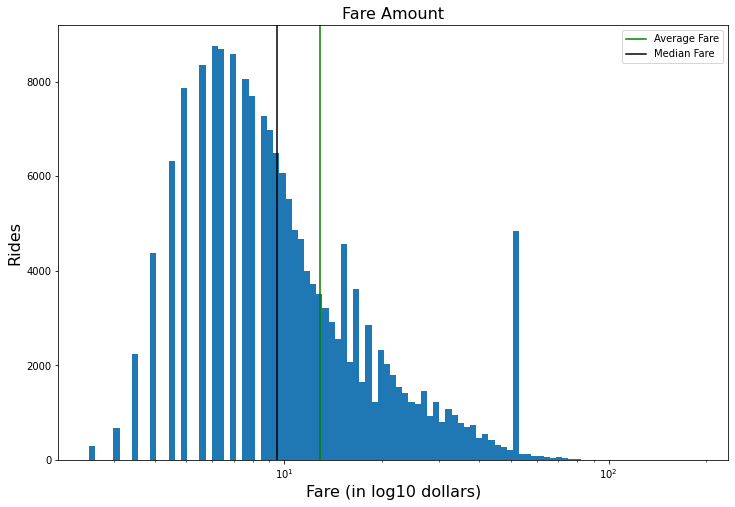

In [116]:
plt.figure(figsize=(12,8))
plot_loghist(data.fare_amount)
plt.title('Fare Amount', fontsize = 16)
plt.ylabel('Rides', fontsize = 16)
plt.xlabel('Fare (in log10 dollars)', fontsize = 16)
plt.axvline(x=data.fare_amount.mean(), color = 'green', label = 'Average Fare')
plt.axvline(x=data.fare_amount.median(), color = 'black', label = 'Median Fare')
plt.legend()
plt.show()

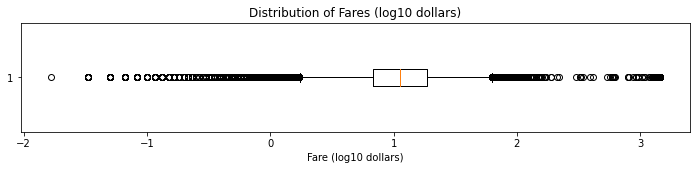

In [117]:
# Box Plot of Fares
plt.figure(figsize=(12,2))
plt.boxplot(np.log10(data.trip_duration), whis=[1, 99], vert = False) #1st and 99th percentiles and the outliers beyond them
plt.title('Distribution of Fares (log10 dollars)')
plt.xlabel("Fare (log10 dollars)")
plt.show()

## Feature Description: `tip_amount` (Tip Amount)

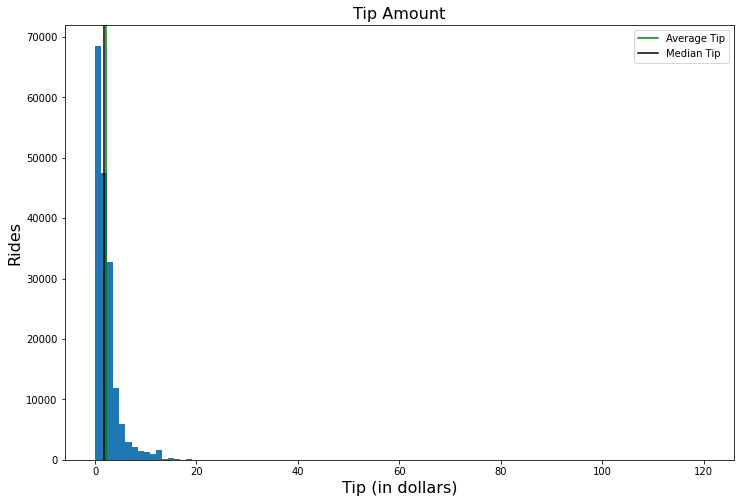

In [118]:
plt.figure(figsize=(12,8))
plt.hist(data.tip_amount, bins = 100)
plt.title('Tip Amount', fontsize = 16)
plt.ylabel('Rides', fontsize = 16)
plt.xlabel('Tip (in dollars)', fontsize = 16)
plt.axvline(x=data.tip_amount.mean(), color = 'green', label = 'Average Tip')
plt.axvline(x=data.tip_amount.median(), color = 'black', label = 'Median Tip')
plt.legend()
plt.show()

In [119]:
print(f"We note that there are a large number of trips with no tip: {data[data.tip_amount == 0].shape[0]} rides.\nWhen cash is used, tips do not need to be recorded.")

We note that there are a large number of trips with no tip: 54143 rides.
When cash is used, tips do not need to be recorded.


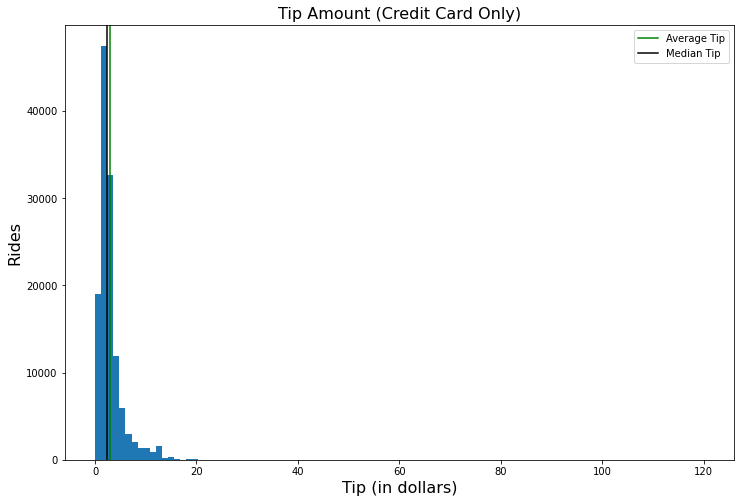

In [120]:
plt.figure(figsize=(12,8))
plt.hist(data[data.payment_type == 1].tip_amount, bins = 100)
plt.title('Tip Amount (Credit Card Only)', fontsize = 16)
plt.ylabel('Rides', fontsize = 16)
plt.xlabel('Tip (in dollars)', fontsize = 16)
plt.axvline(x=data[data.payment_type == 1].tip_amount.mean(), color = 'green', label = 'Average Tip')
plt.axvline(x=data[data.payment_type == 1].tip_amount.median(), color = 'black', label = 'Median Tip')
plt.legend()
plt.show()

In [121]:
print(f"Now there are {data[(data.payment_type == 1) & (data.tip_amount == 0)].shape[0]} rides with no tip recorded.\nIt is, of course, possible to tip in cash and pay with a credit card.")

Now there are 4595 rides with no tip recorded.
It is, of course, possible to tip in cash and pay with a credit card.


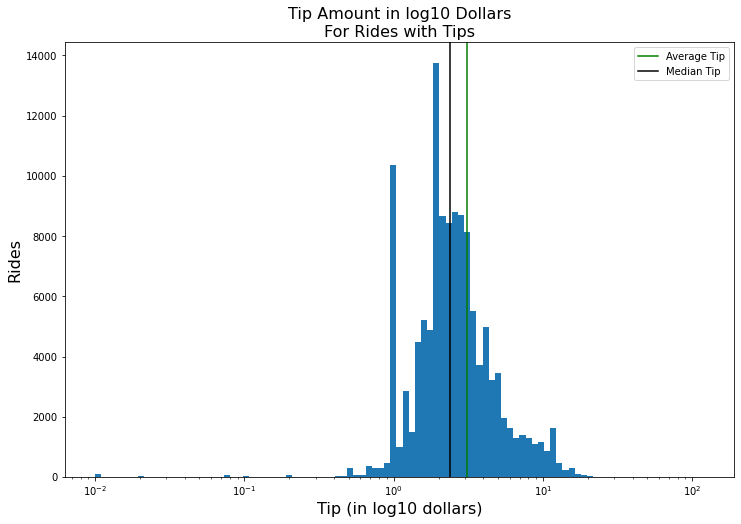

In [122]:
plt.figure(figsize=(12,8))
plot_loghist(data.tip_amount[data.tip_amount > 0])
plt.title('Tip Amount in log10 Dollars\nFor Rides with Tips', fontsize = 16)
plt.ylabel('Rides', fontsize = 16)
plt.xlabel('Tip (in log10 dollars)', fontsize = 16)
plt.axvline(x=data[data.tip_amount > 0].tip_amount.mean(), color = 'green', label = 'Average Tip')
plt.axvline(x=data[data.tip_amount > 0].tip_amount.median(), color = 'black', label = 'Median Tip')
plt.legend()
plt.show()

In [123]:
print(f"Given that the minimum tip indicated is {data[data.tip_amount > 0].tip_amount.describe()['min']}, we suspect this is due to a rounding up from the fare ending in 99 cents. Hopefully there was an additional tip in cash!")

Given that the minimum tip indicated is 0.01, we suspect this is due to a rounding up from the fare ending in 99 cents. Hopefully there was an additional tip in cash!


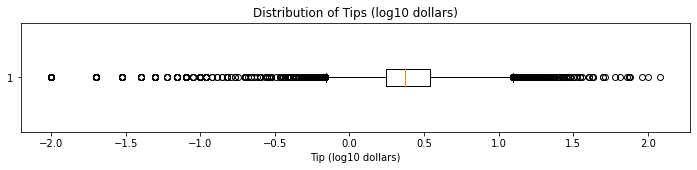

In [124]:
# Box Plot of Tips
plt.figure(figsize=(12,2))
plt.boxplot(np.log10(data[data.tip_amount > 0].tip_amount), whis=[1, 99], vert = False) #1st and 99th percentiles and the outliers beyond them
plt.title('Distribution of Tips (log10 dollars)')
plt.xlabel("Tip (log10 dollars)")
plt.show()

## <center>6. Spatial Analyses<a name="Analyses"></a></center>

In [125]:
# Taxi Zones
taxi = gpd.read_file('https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=Shapefile')
taxi.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


<AxesSubplot:>

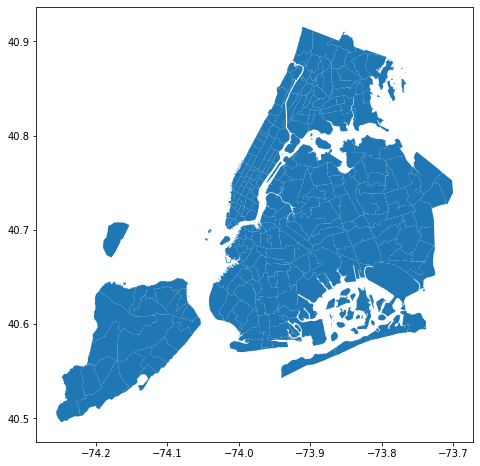

In [126]:
taxi.plot(figsize=(8,8))

In [127]:
print(f"The number of pickup location IDs from our sample that lie outside these taxi zones is: {len(data[~data.PULocationID.isin(taxi.location_i)])}.")

The number of pickup location IDs from our sample that lie outside these taxi zones is: 1464.


In [128]:
print(f"The number of dropoff location IDs from our sample that lie outside these taxi zones is: {len(data[~data.DOLocationID.isin(taxi.location_i)])}.")

The number of dropoff location IDs from our sample that lie outside these taxi zones is: 1322.


### Spatial Filtering
We filter the data to include trips only that start and end in NYC or EWR.

In [129]:
data = data[(data.PULocationID.isin(taxi.location_i)) & (data.DOLocationID.isin(taxi.location_i))]
data.shape

(176043, 25)

### Spatial Distributions

In [130]:
tripsByZone = data.groupby(by='PULocationID', as_index=False).count()[['PULocationID', 'DOLocationID']]
tripsByZone.rename(columns={'DOLocationID':'N_trips'}, inplace=True)
tripsByZone.head()

,PULocationID,N_trips
0,3,2
1,4,282
2,6,1
3,7,249
4,8,1


## <center>7. Visualizations<a name="Visualizations"></a></center>

In [131]:
tripsViz = taxi.merge(tripsByZone, left_on='location_i', right_on='PULocationID')
tripsViz.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry,PULocationID,N_trips
0,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",3,2
1,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",4,282
2,Staten Island,6.0,6.0,0.000606,0.150491,Arrochar/Fort Wadsworth,"POLYGON ((-74.06367 40.60220, -74.06351 40.602...",6,1
3,Queens,7.0,7.0,0.000390,0.107417,Astoria,"POLYGON ((-73.90414 40.76752, -73.90325 40.767...",7,249
4,Queens,8.0,8.0,0.000027,0.027591,Astoria Park,"POLYGON ((-73.92334 40.77513, -73.92398 40.774...",8,1


<AxesSubplot:>

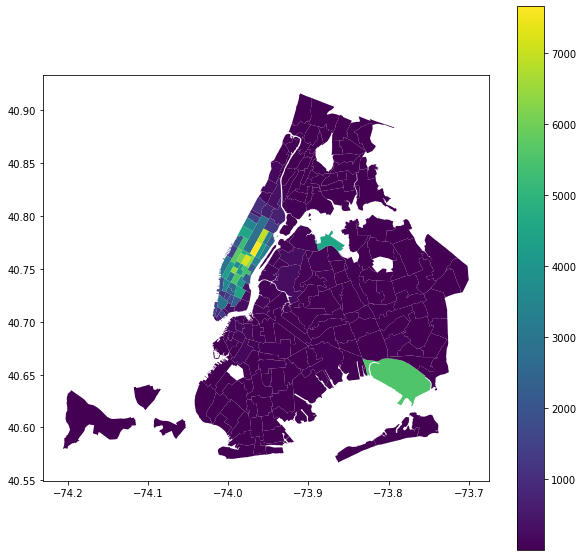

In [132]:
#Heatmap for the number of trips per taxi zone on NYC map
tripsViz.plot(figsize=(10,10), column='N_trips', legend=True)

#### NOTE: 

* This is not a very good visualization since too many trips are concentrated in Manhattan and JFK, LaGuardia airports as compared to other areas.Therefore, these areas completely dominate the colormap. 

* A better way to visualize might be to split the activity in quantiles and assign colors to quantiles

<AxesSubplot:>

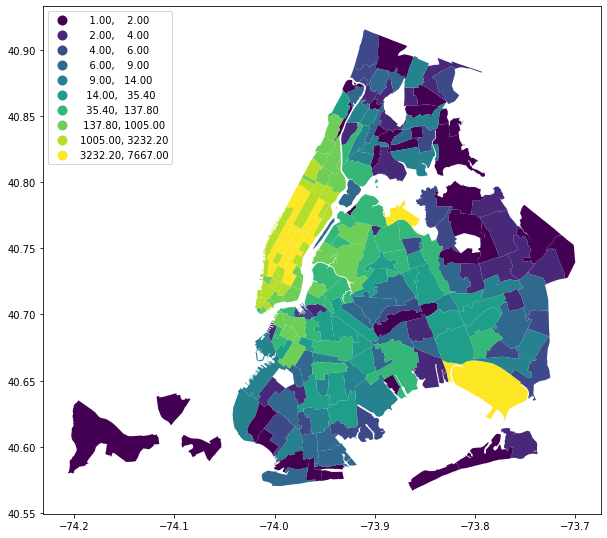

In [133]:
fig, ax = plt.subplots(1, figsize=(10,10))

tripsViz.plot(ax=ax, column='N_trips', k=10, scheme='Quantiles', legend=True, 
              legend_kwds={'loc': 'upper left'})

#### Plot the activity density that is normalized by zipcode shape area

One important issue to mind with visualizing aggregated activity is the homogeniety of spatial units!

Taxi zones are all of different size, while the activity heatmap is usually perceived as a density map. However the quantity above is affected by both - activity density as well as the size of the unit which is somewhat arbitrary. 

Therefore, we should normalize activity by the area (trips per sq. mile) or by population (trips per capita).

In [134]:
#Let's find out the activity density, normalized by zipcode shape area
tripsViz['ActivityDensity'] = tripsViz['N_trips'] / tripsViz['shape_area']

<AxesSubplot:>

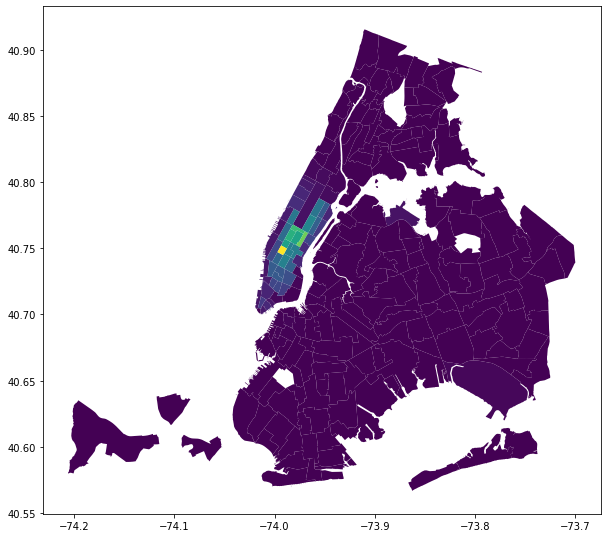

In [135]:
#consider density heatmap without percentiles first 
tripsViz.plot(figsize = (10,10), column='ActivityDensity', legend=False)

<AxesSubplot:>

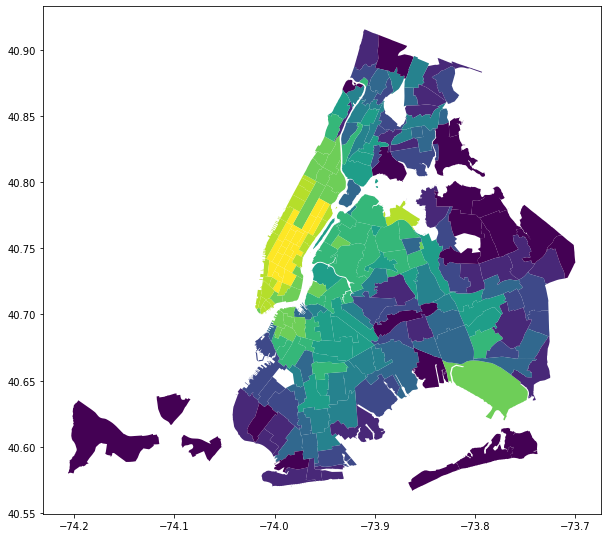

In [136]:
# Again, color map does not visualize properly. Let's use quantiles again!
tripsViz.plot(figsize = (10,10), column='ActivityDensity', scheme='Quantiles', k=10, legend=False)

#### Travel Density Normalized by Dropoff Location

In [137]:
#get the number of trips by drop off location
tripsBydrop = data.groupby(by='DOLocationID', as_index=False).count()[['DOLocationID', 'PULocationID']]
tripsBydrop.rename(columns={'PULocationID':'N_trips'}, inplace=True)
tripsBydrop.head()

,DOLocationID,N_trips
0,1,4
1,3,13
2,4,754
3,5,1
4,6,2


In [138]:
tripsVizdrop = taxi.merge(tripsBydrop, left_on='location_i', right_on='DOLocationID')
# merge with taxi zone shapefile first
#trips per square mile, area normalization
tripsVizdrop['ActivityDensitydrop'] = tripsVizdrop['N_trips'] / tripsVizdrop['shape_area']

tripsVizdrop.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry,DOLocationID,N_trips,ActivityDensitydrop
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",1,4,5.113084e+03
1,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",3,13,4.134674e+04
2,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",4,754,6.739849e+06
3,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",5,1,2.008204e+03
4,Staten Island,6.0,6.0,0.000606,0.150491,Arrochar/Fort Wadsworth,"POLYGON ((-74.06367 40.60220, -74.06351 40.602...",6,2,3.297821e+03


<AxesSubplot:>

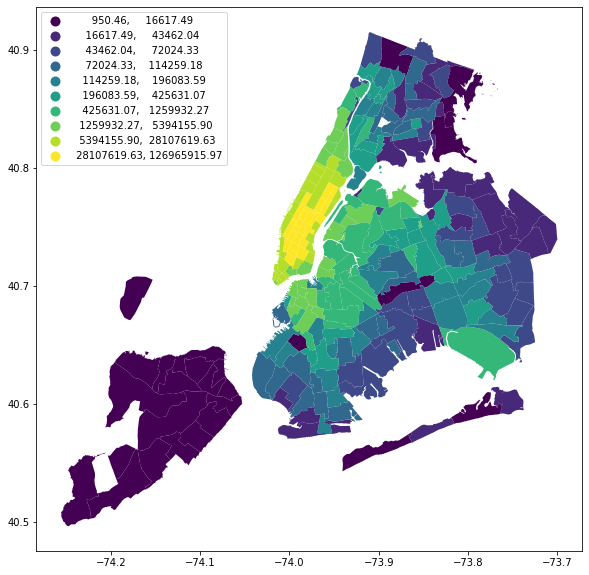

In [139]:
# quantile visualization

tripsVizdrop.plot(figsize = (10,10), column='ActivityDensitydrop', scheme='Quantiles', k=10,legend=True,
                 legend_kwds={'loc': 'upper left'})

### Top 10/Bottom 10 in terms of Trip Density

In [140]:
#get the number of trips by pickup location
tripsByZone1 = data.groupby(by='PULocationID', as_index=False).count()[['PULocationID', 'DOLocationID']]
tripsByZone1.rename(columns={'DOLocationID':'Ntrips1'}, inplace=True)
tripsByZone1.head()

,PULocationID,Ntrips1
0,3,2
1,4,282
2,6,1
3,7,249
4,8,1


In [141]:
#merging
tripsViz1 = taxi.merge(tripsByZone1, left_on='location_i', right_on='PULocationID')

# finding density by Pickup location 
tripsViz1['Activity_Density1'] = tripsViz1['Ntrips1'] / tripsViz1['shape_area']

#sorting top 10 and bottom ten
tripactsorted=tripsViz1.sort_values(by='Activity_Density1', ascending=True)
bottomten=tripactsorted.head(10)
topten=tripactsorted.tail(10)

(-74.23131288488669, -73.67470888198534, 40.5493636726913, 40.9329694010174)

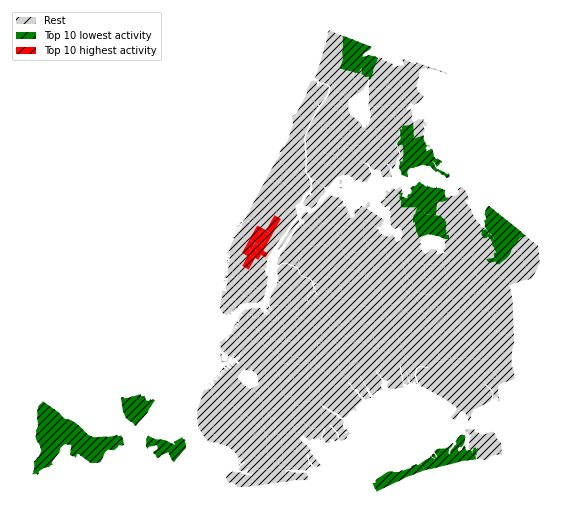

In [142]:
#visualizing on map
import matplotlib.patches as mpatches
fig,ax = plt.subplots(figsize=(10,10))
tripactsorted.plot(facecolor='lightgrey',hatch='///',ax=ax)
bottomten.plot(facecolor='green',hatch='///',ax=ax)
topten.plot(facecolor='red',hatch='///',ax=ax)

LegendElement = [
                mpatches.Patch(facecolor='lightgrey', hatch='//', label='Rest'),
                mpatches.Patch(facecolor='green', hatch='//', label='Top 10 lowest activity'),
                mpatches.Patch(facecolor='red', hatch='//', label='Top 10 highest activity')
                ]
ax.legend(handles = LegendElement, loc='upper left')
ax.axis('off')

### Travel Speed by Pickup Location

In [143]:
#finding average speed
tripsByspeed = data.groupby(by=['PULocationID'], as_index=False).sum()[['PULocationID', 'trip_distance', 'trip_duration']]
tripsByspeed['avg_speed'] = tripsByspeed['trip_distance']/(tripsByspeed['trip_duration']/60)
tripsByspeed.head()

,PULocationID,trip_distance,trip_duration,avg_speed
0,3,6.76,25.533333,15.885117
1,4,758.45,3918.533333,11.613274
2,6,1.66,3.966667,25.109244
3,7,765.28,5245.616667,8.753366
4,8,4.95,16.433333,18.073022


In [144]:
# merge with taxi zone shapefile first
tripsVizSpeed = taxi.merge(tripsByspeed, left_on='location_i', right_on='PULocationID')

Text(0.5, 1.0, 'avg speed mph')

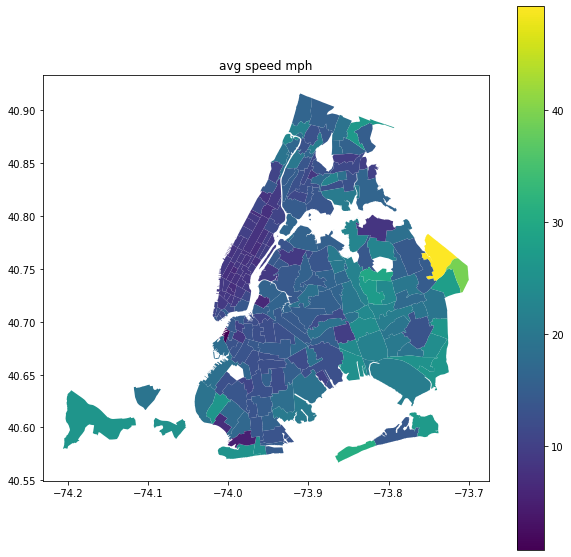

In [145]:
tripsVizSpeed.plot(figsize=(10,10), column='avg_speed', legend=True)
plt.title('avg speed mph')

Text(0.5, 1.0, 'avg speed mph')

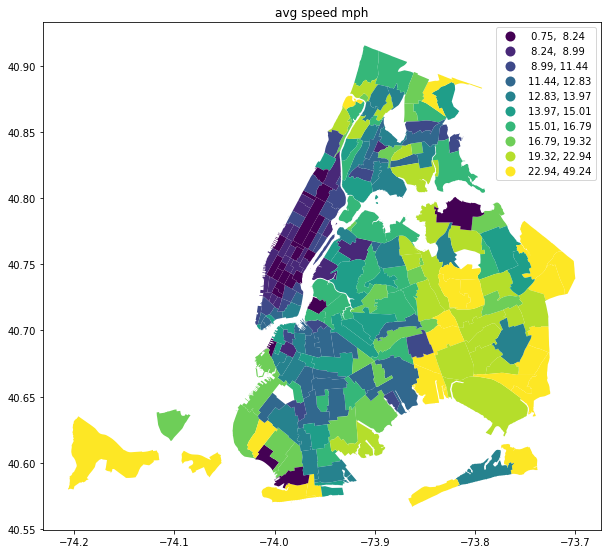

In [146]:
#now by percentile 
tripsVizSpeed.plot(figsize = (10,10), column='avg_speed', scheme='Quantiles', k=10, legend=True)
plt.title('avg speed mph')

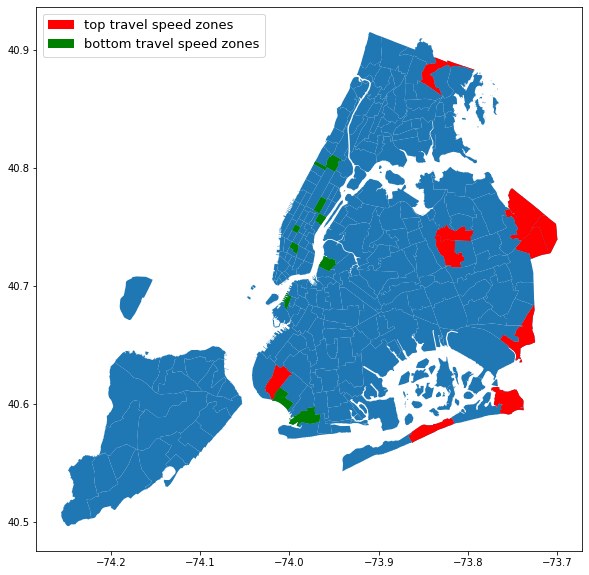

In [147]:
#Visualize the top 10 and botton 10 areas by average speed
fig, ax = plt.subplots(figsize=(10,10))

taxi.plot(ax=ax)
tripsVizSpeed.sort_values(by='avg_speed', ascending=False)[:10].plot(color='red', ax=ax)
tripsVizSpeed.sort_values(by='avg_speed', ascending=True)[:10].plot(color='green', ax=ax)
LegendElement = [
                mpatches.Patch(facecolor='red', label='top travel speed zones'),
                mpatches.Patch(facecolor='green', label='bottom travel speed zones'),
                ]
ax.legend(handles = LegendElement, loc='upper left', fontsize=13)

### Average Trip Distance by Pickup Location

In [148]:
#group trips by total trip distance
tripsBydist = data[['trip_distance', 'PULocationID']].groupby(by='PULocationID', as_index=False).sum()
tripsBydist.head()

,PULocationID,trip_distance
0,3,6.76
1,4,758.45
2,6,1.66
3,7,765.28
4,8,4.95


<AxesSubplot:>

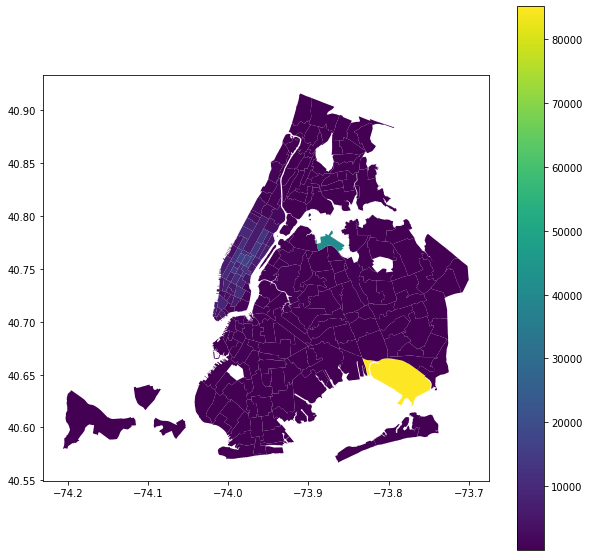

In [149]:
tripsVizdist = taxi.merge(tripsBydist, left_on='location_i', right_on='PULocationID')
tripsVizdist.plot(figsize=(10,10), column='trip_distance', legend=True)

<AxesSubplot:>

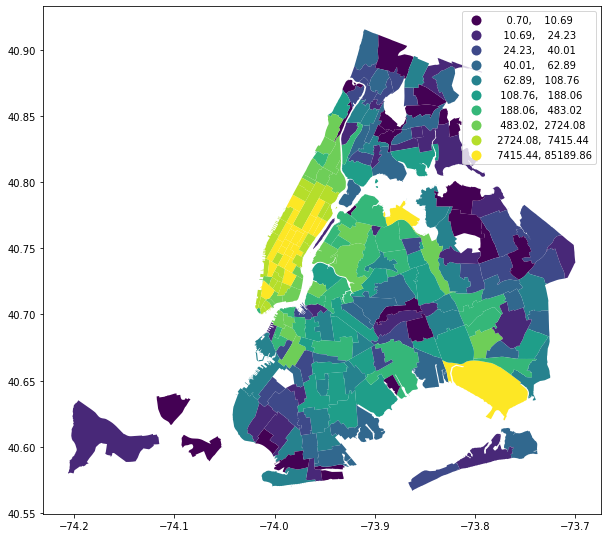

In [150]:
#now by percentile 
tripsVizdist.plot(figsize = (10,10), column='trip_distance', scheme='Quantiles', k=10, legend=True)

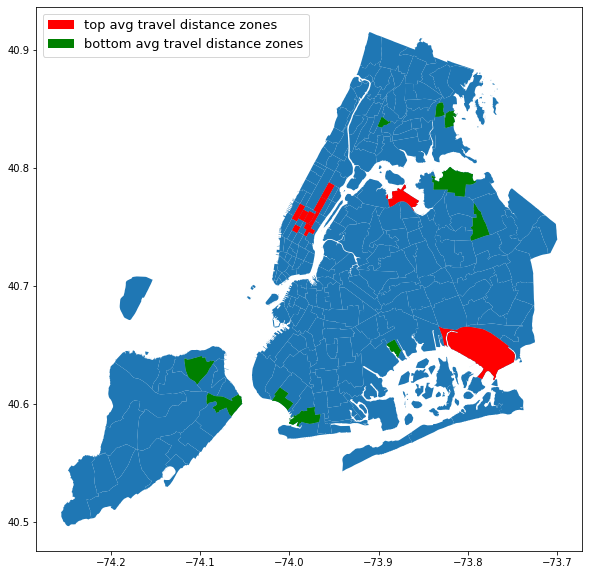

In [151]:
#Visualize the top 10 and botton 10 areas by average distance 
fig, ax = plt.subplots(figsize=(10,10))

taxi.plot(ax=ax)
tripsVizdist.sort_values(by='trip_distance', ascending=False)[:10].plot(color='red', ax=ax)
tripsVizdist.sort_values(by='trip_distance', ascending=True)[:10].plot(color='green', ax=ax)
LegendElement = [
                mpatches.Patch(facecolor='red', label='top avg travel distance zones'),
                mpatches.Patch(facecolor='green', label='bottom avg travel distance zones'),
                ]
ax.legend(handles = LegendElement, loc='upper left', fontsize=13)


###  Heat Map of tips per minute & tips per mile

In [152]:
#Add tips per minute to data, determine average tips per minute by location
data['tips_per_minute'] = data['tip_amount'] / data['trip_duration']
tipsPerMin = data.groupby('PULocationID').mean()[['tips_per_minute']]

/Users/alexherron/opt/miniconda3/envs/torch/lib/python3.8/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/Users/alexherron/opt/miniconda3/envs/torch/lib/python3.8/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 5
  Warn("Warning: setting k to %d" % k_q, UserWarning)


<AxesSubplot:>

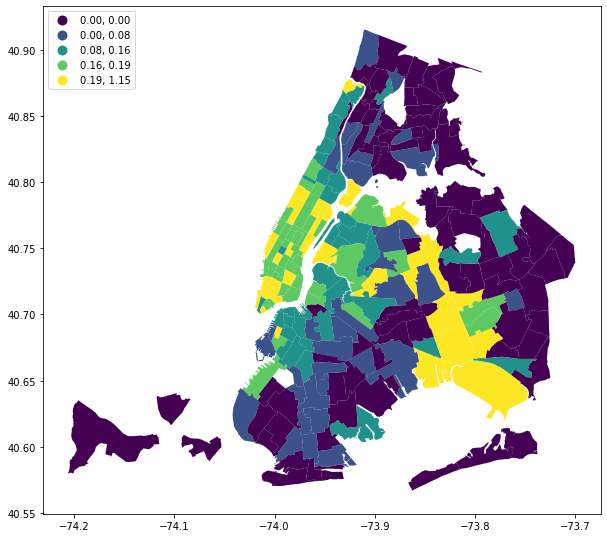

In [153]:
#Merge with taxi zone shapefile, plot heat map
tipsPerMinViz = taxi.merge(tipsPerMin, left_on='location_i', right_on='PULocationID')
tipsPerMinViz.plot(figsize = (10,10), column = 'tips_per_minute', scheme = 'Quantiles', k = 6,
                 legend = True, legend_kwds = {'loc': 'upper left'})

In [154]:
#Add tips per mile to data, determine average tips per mile by location
data['tips_per_mile'] = data['tip_amount'] / data['trip_distance']
tipsPerMile = data.groupby('PULocationID').mean()[['tips_per_mile']]

/Users/alexherron/opt/miniconda3/envs/torch/lib/python3.8/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/Users/alexherron/opt/miniconda3/envs/torch/lib/python3.8/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 5
  Warn("Warning: setting k to %d" % k_q, UserWarning)


<AxesSubplot:>

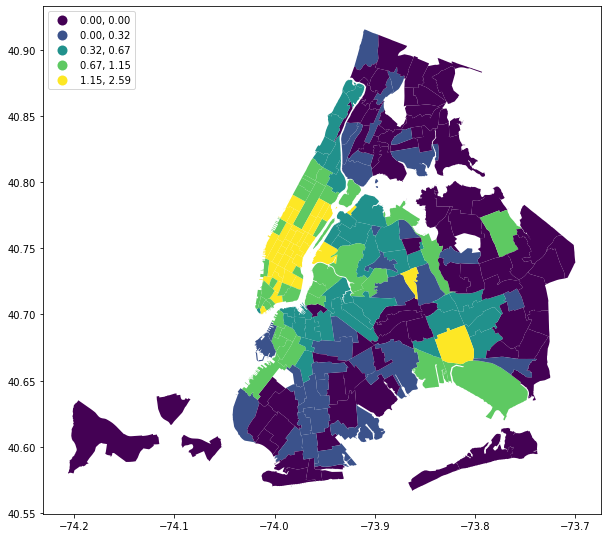

In [155]:
#Merge with taxi zone shapefile, plot heat map
tipsPerMileViz = taxi.merge(tipsPerMile, left_on='location_i', right_on='PULocationID')
tipsPerMileViz.plot(figsize = (10,10), column = 'tips_per_mile', scheme = 'Quantiles', k = 6,
                 legend = True, legend_kwds = {'loc': 'upper left'})